# Results Processing

## Imports and variables used throughout file

Load results dataframe from pickle file

In [64]:
from dir_paths import PROCESSED_DATA_DIR, FIGURES_SIMULATIONS_DIR
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
import numpy as np

# Configure matplotlib to use LaTeX
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize": [10, 6],
    "savefig.dpi": 300,
    "savefig.format": "pdf"
})

AXIS_FONT_SIZE = 14
TITLE_FONT_SIZE = 16
TICKS_FONT_SIZE = 14
LEGEND_FONT_SIZE = 14

# Define consistent colors for algorithms - more appealing palette
FIFO_COLOR = '#1f77b4'  # Professional blue
LRU_COLOR = '#ff7f0e'   # Vibrant orange  
SIEVE_COLOR = '#2ca02c'  # Fresh green

# Color mapping dictionary
ALGORITHM_COLORS = {
    'FIFO': FIFO_COLOR,
    'LRU': LRU_COLOR,
    'SIEVE': SIEVE_COLOR
}

# Load results_df from pickle file
results_df = pd.read_pickle(f"{PROCESSED_DATA_DIR}/results_df.pkl")

## Miss ratio vs. relative cache size

### Violin plots

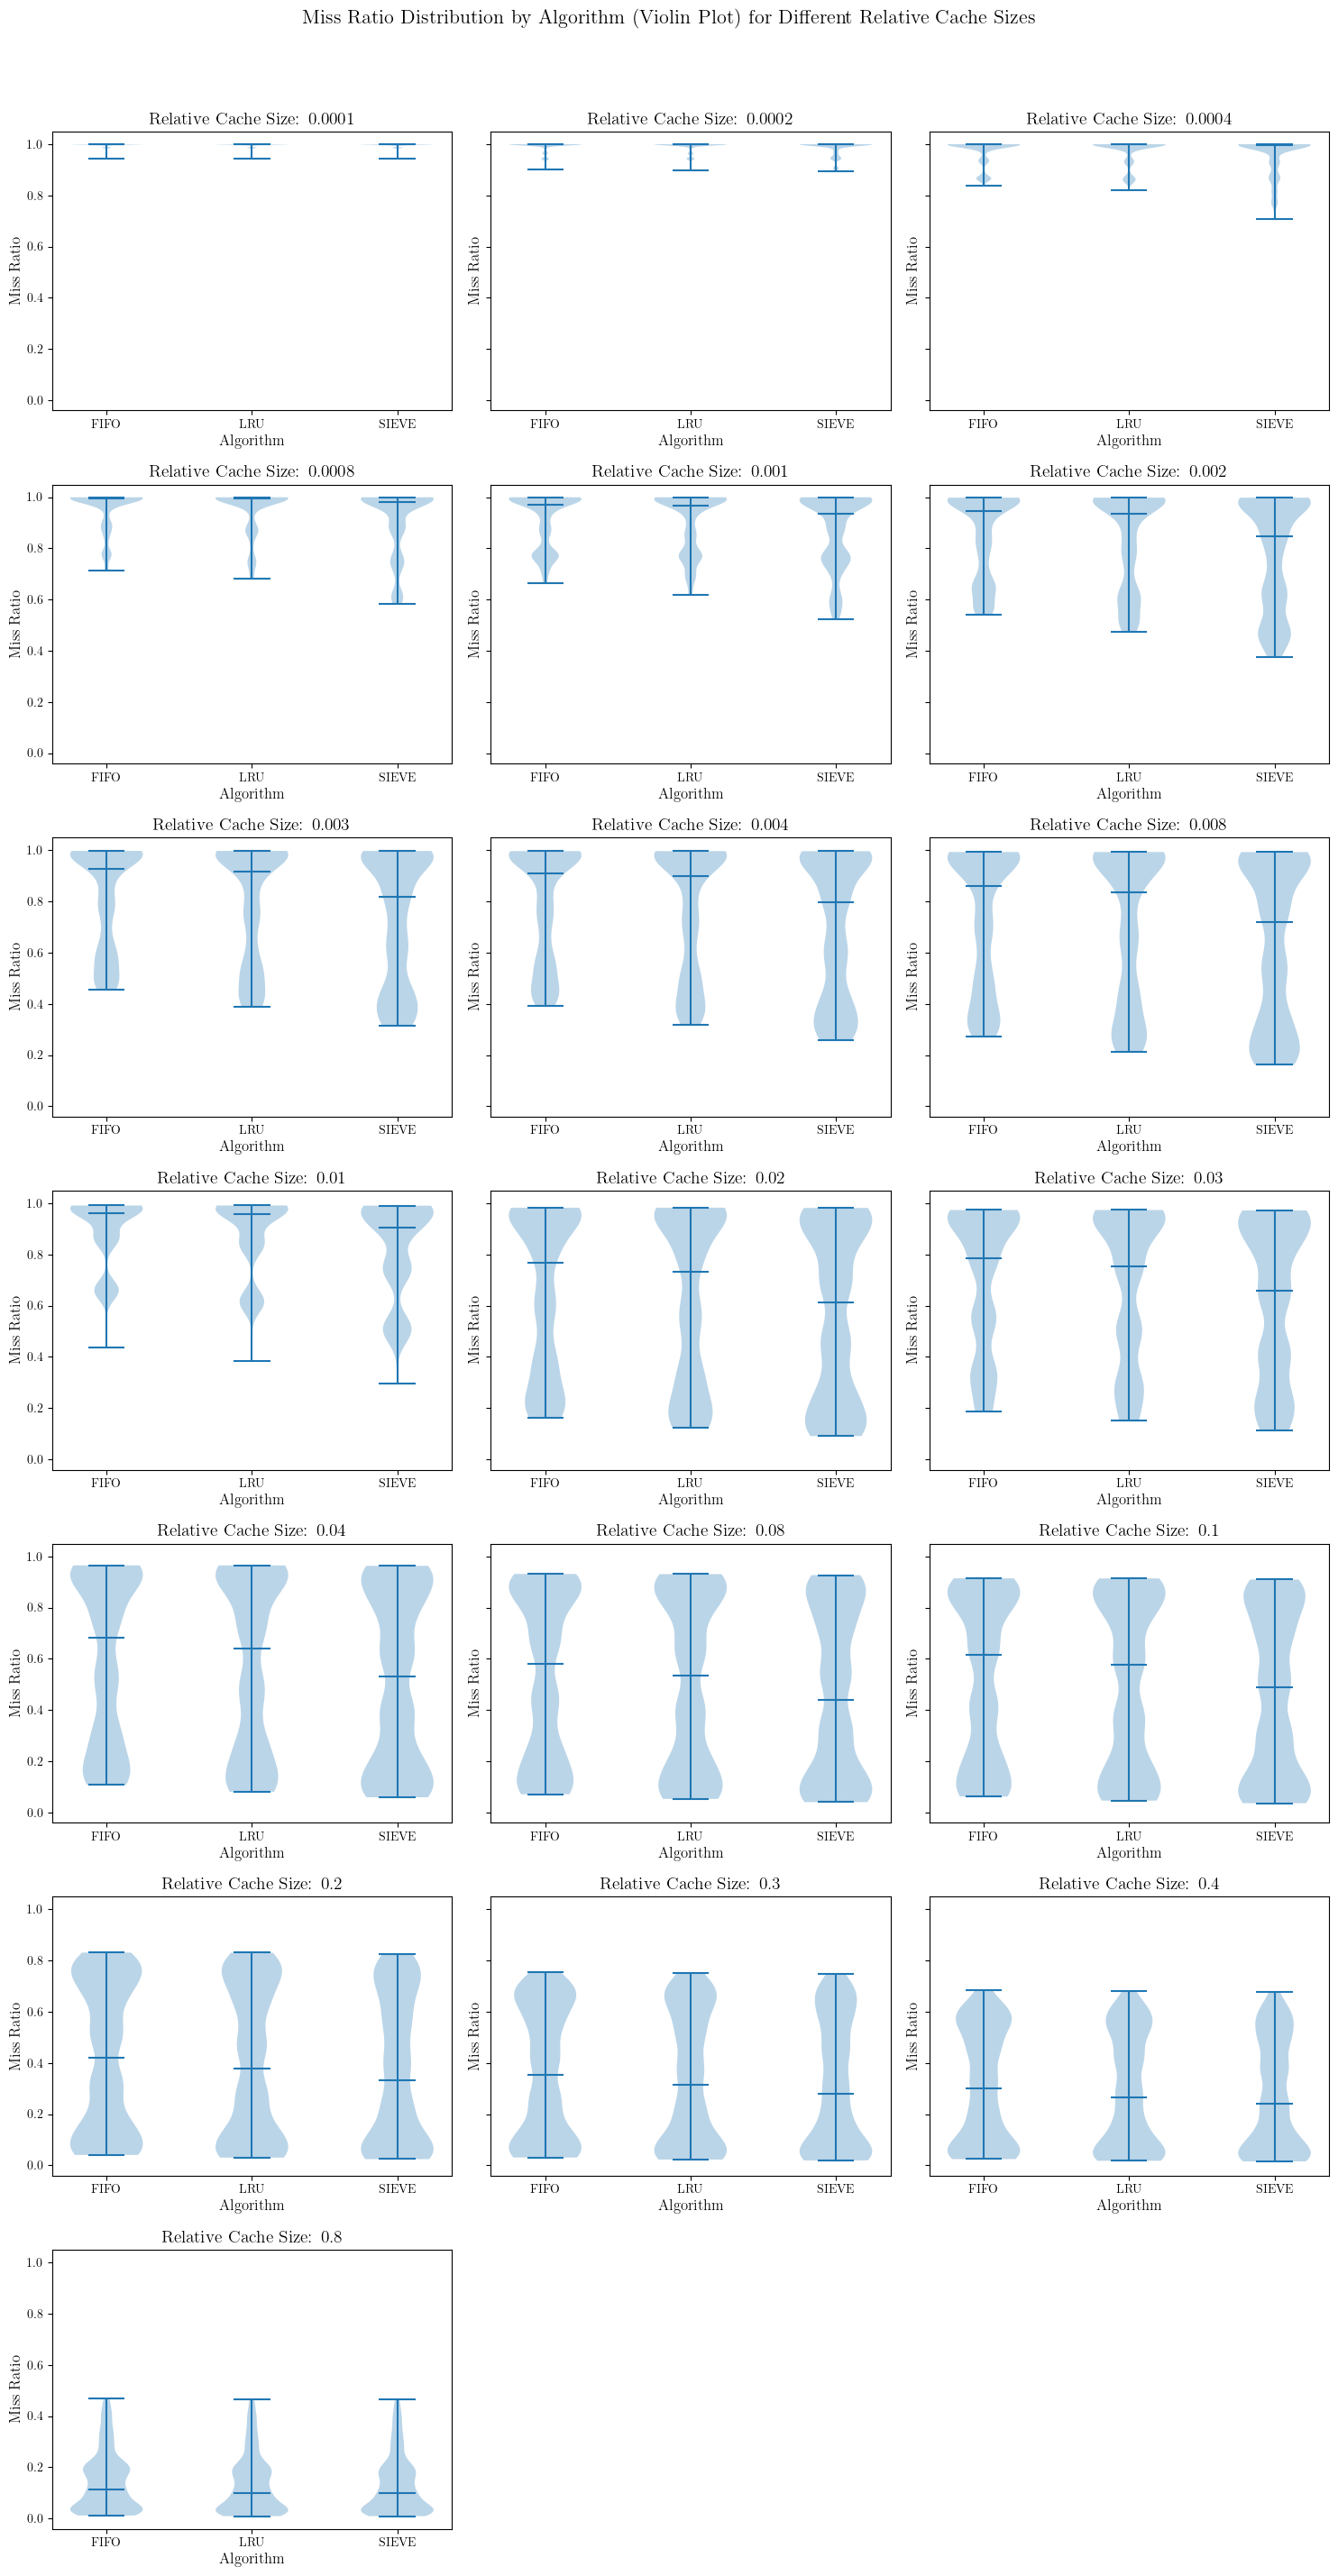

In [65]:
# Violin plots for miss ratio distribution by algorithm for each cache size
unique_sizes = sorted(results_df['cache_size_relative_rounded'].unique())
n_sizes = len(unique_sizes)
n_cols = 3
n_rows = (n_sizes + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), sharey=True)
axs = axs.flatten()

for i, size in enumerate(unique_sizes):
    subset = results_df[results_df['cache_size_relative_rounded'] == size]
    ax = axs[i]
    subset_violin = [subset[subset['algorithm'] == algo]['miss_ratio'] for algo in subset['algorithm'].unique()]
    ax.violinplot(subset_violin, showmeans=False, showmedians=True)
    ax.set_xticks(range(1, len(subset['algorithm'].unique()) + 1))
    ax.set_xticklabels(subset['algorithm'].unique())
    ax.set_title(f'Relative Cache Size: {size}')
    ax.set_xlabel('Algorithm')
    ax.set_ylabel('Miss Ratio')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle('Miss Ratio Distribution by Algorithm (Violin Plot) for Different Relative Cache Sizes', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### Boxplot per relative cache size

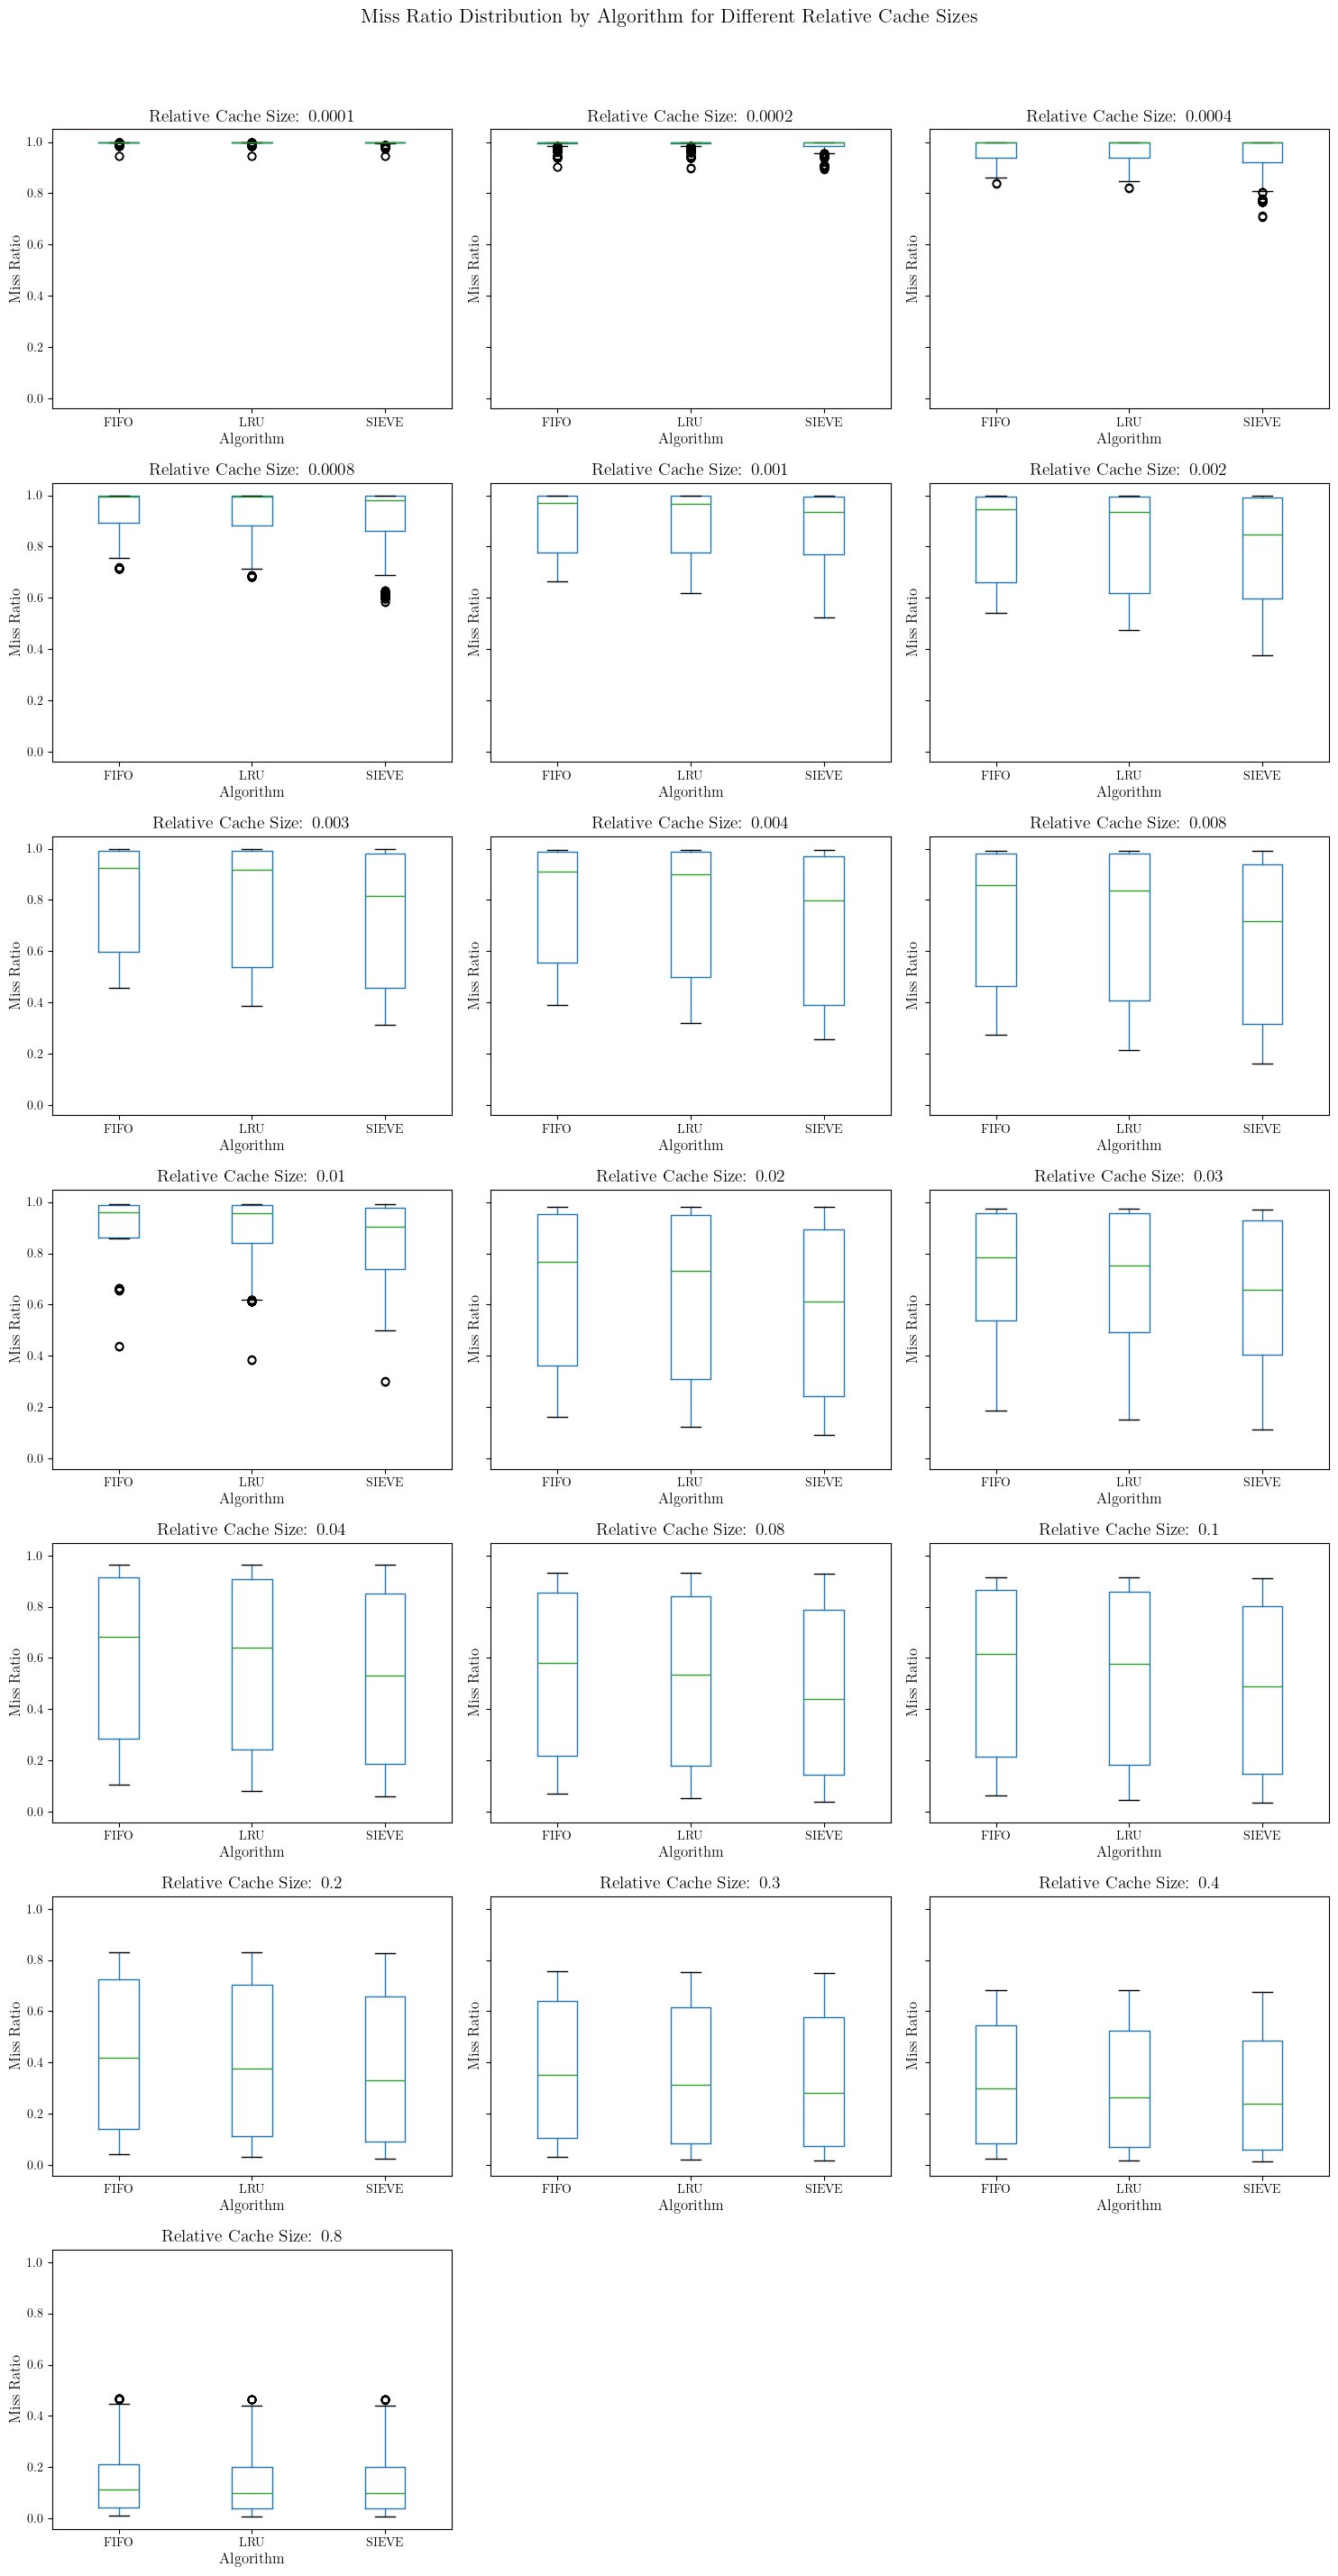

In [66]:
# Plot miss ratio distribution per algorithm for each relative cache size using boxplots and violin plots
unique_sizes = sorted(results_df['cache_size_relative_rounded'].unique())
n_sizes = len(unique_sizes)
n_cols = 3
n_rows = (n_sizes + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), sharey=True)
axs = axs.flatten()

for i, size in enumerate(unique_sizes):
    subset = results_df[results_df['cache_size_relative_rounded'] == size]
    ax = axs[i]
    subset.boxplot(column='miss_ratio', by='algorithm', ax=ax, grid=False)
    ax.set_title(f'Relative Cache Size: {size}')
    ax.set_xlabel('Algorithm')
    ax.set_ylabel('Miss Ratio')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle('Miss Ratio Distribution by Algorithm for Different Relative Cache Sizes', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### Line plot (linear + log)

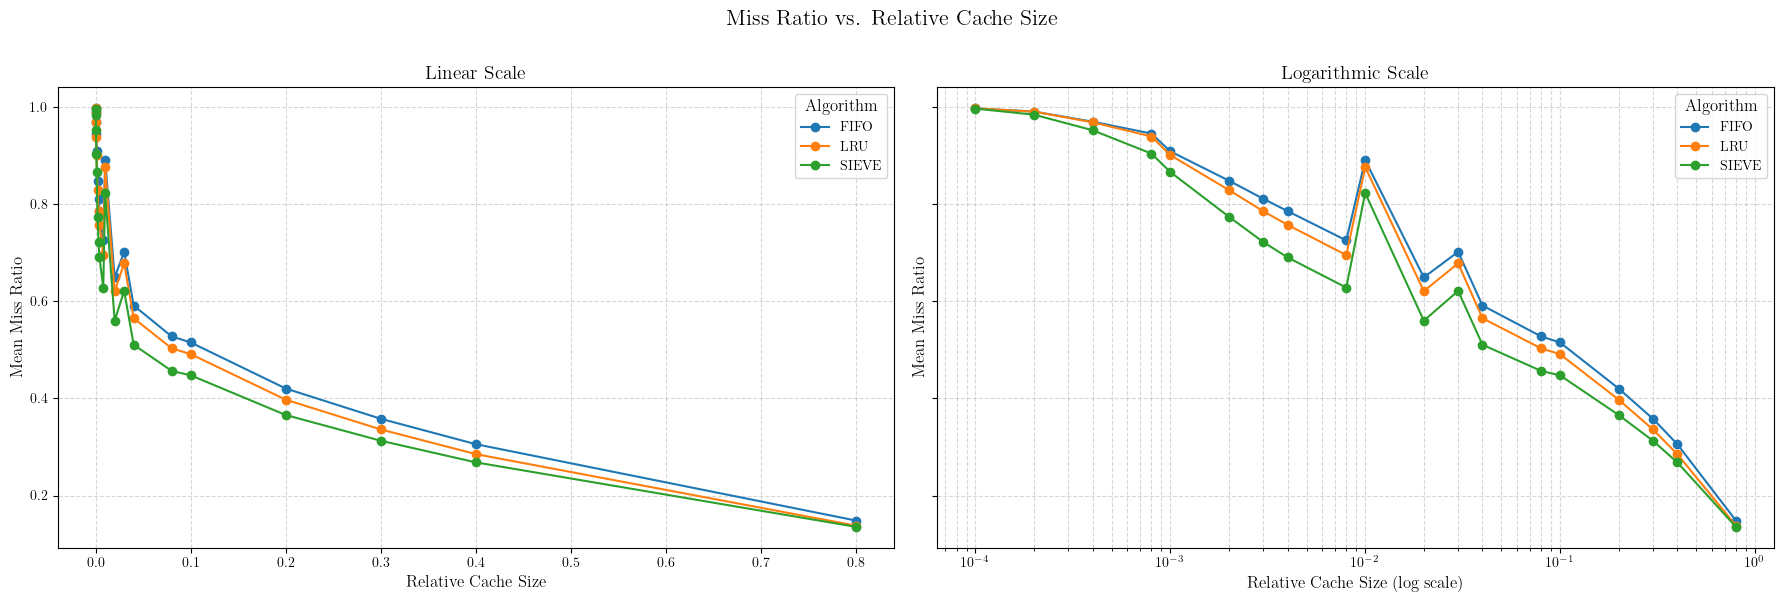

In [67]:
# Group by algorithm and cache_size_relative_rounded, aggregate mean miss ratio
agg_mean = results_df.groupby(['algorithm', 'cache_size_relative_rounded'])['miss_ratio'].mean().reset_index()
filenames = {"both" : "miss_ratio_vs_cache_size_both.pdf",
             "log" : "miss_ratio_vs_cache_size_log.pdf",
             "linear" : "miss_ratio_vs_cache_size_linear.pdf"}

def plot_miss_ratio_vs_cache_size_no_error(
    agg_df,
    scale='both',
    figsize=(18, 6),
    marker='o',
    save_fig=False
):
    """
    Plot miss ratio vs. relative cache size without error bars.

    Parameters:
        agg_df (pd.DataFrame): Aggregated dataframe with columns ['algorithm', 'cache_size_relative_rounded', 'miss_ratio']
        scale (str): 'linear', 'log', or 'both'
        figsize (tuple): Figure size
        marker (str): Marker style
    """
    scales = []

    if scale == 'both':
        scales = ['linear', 'log']
    else:
        scales = [scale]
        
    n_plots = len(scales)
    _, axs = plt.subplots(1, n_plots, figsize=figsize,
                          sharey=True if n_plots > 1 else False)

    if n_plots == 1:
        axs = [axs]

    if scale == 'both': plt.suptitle('Miss Ratio vs. Relative Cache Size', fontsize=16, y=1)

    for i, sc in enumerate(scales):
        for algo in agg_df['algorithm'].unique():
            df_algo = agg_df[agg_df['algorithm'] == algo]
            axs[i].plot(
                df_algo['cache_size_relative_rounded'],
                df_algo['miss_ratio'],
                marker=marker,
                label=algo,
                color=ALGORITHM_COLORS.get(algo, 'black')
            )
        axs[i].set_xlabel('Relative Cache Size' +
                          (' (log scale)' if sc == 'log' else ''))
        axs[i].set_ylabel('Mean Miss Ratio')

        # Add main title above both subplots if more than one algorithm is present and both scales are plotted
        if len(agg_df['algorithm'].unique()) > 1 and n_plots > 1:
            axs[i].set_title('Logarithmic Scale' if sc == 'log' else 'Linear Scale')
        else:
            axs[i].set_title("Miss Ratio vs. Relative Cache Size" + (" (log scale)" if sc == 'log' else ""), fontsize=16)
        axs[i].grid(True, which='both', linestyle='--', alpha=0.5)

        axs[i].legend(title='Algorithm')

        if sc == 'log':
            axs[i].set_xscale('log')

    plt.tight_layout()

    if save_fig:
        plt.savefig(os.path.join(FIGURES_SIMULATIONS_DIR, filenames[scale]), bbox_inches='tight')
    plt.show()

plot_miss_ratio_vs_cache_size_no_error(agg_mean, scale='both', save_fig=False)




### Stats & tables

In [68]:
# Overview table: Mean miss ratio by algorithm and relative cache size
print("=== MEAN MISS RATIO OVERVIEW TABLE ===")
print("Mean Miss Ratio by Algorithm and Relative Cache Size")
print("=" * 70)

# Create pivot table with mean miss ratios
overview_table = results_df.pivot_table(
    values='miss_ratio', 
    index='cache_size_relative_rounded', 
    columns='algorithm', 
    aggfunc='mean'
).round(4)

# Display the table with proper formatting
print(f"{'Cache Size':<12} ", end="")
for algo in overview_table.columns:
    print(f"{algo:<10} ", end="")
print()
print("-" * 70)

for cache_size, row in overview_table.iterrows():
    print(f"{cache_size:<12.4f} ", end="")
    for algo in overview_table.columns:
        value = row[algo]
        if pd.isna(value):
            print(f"{'N/A':<10} ", end="")
        else:
            print(f"{value:<10.4f} ", end="")
    print()

print("=" * 70)

# Summary statistics for the table
print(f"\nTABLE SUMMARY:")
print(f"Number of cache sizes: {len(overview_table.index)}")
print(f"Number of algorithms: {len(overview_table.columns)}")
print(f"Cache size range: {overview_table.index.min():.4f} - {overview_table.index.max():.4f}")

# Show overall algorithm performance ranking
print(f"\nOVERALL ALGORITHM RANKING (by mean miss ratio):")
overall_means = overview_table.mean().sort_values()
print(f"{'Rank':<6} {'Algorithm':<12} {'Mean Miss Ratio':<16}")
print("-" * 35)
for rank, (algo, mean_miss) in enumerate(overall_means.items(), 1):
    print(f"{rank:<6} {algo:<12} {mean_miss:<16.4f}")

print(f"\n" + "=" * 70)

=== MEAN MISS RATIO OVERVIEW TABLE ===
Mean Miss Ratio by Algorithm and Relative Cache Size
Cache Size   FIFO       LRU        SIEVE      
----------------------------------------------------------------------
0.0001       0.9976     0.9976     0.9971     
0.0002       0.9910     0.9909     0.9846     
0.0004       0.9701     0.9689     0.9525     
0.0008       0.9457     0.9397     0.9045     
0.0010       0.9091     0.9014     0.8665     
0.0020       0.8487     0.8293     0.7744     
0.0030       0.8114     0.7858     0.7223     
0.0040       0.7860     0.7576     0.6906     
0.0080       0.7256     0.6953     0.6284     
0.0100       0.8910     0.8768     0.8233     
0.0200       0.6494     0.6212     0.5603     
0.0300       0.7021     0.6784     0.6215     
0.0400       0.5915     0.5653     0.5107     
0.0800       0.5278     0.5032     0.4568     
0.1000       0.5154     0.4913     0.4477     
0.2000       0.4205     0.3975     0.3659     
0.3000       0.3581     0.3362     0.3

In [69]:
# Comprehensive table: Mean miss ratio by algorithm and relative cache size
print("=== SIMULATION OVERVIEW TABLE ===")
print("Mean Miss Ratio, Standard Deviation, and Number of Simulations")
print("by Algorithm and Relative Cache Size")
print("=" * 80)

# Create detailed statistics table
detailed_stats = results_df.groupby(['algorithm', 'cache_size_relative_rounded'])['miss_ratio'].agg([
    'count',   # number of simulations
    'mean',    # mean miss ratio
    'std',     # standard deviation
    'min',     # minimum miss ratio
    'max'      # maximum miss ratio
]).round(4)

# Reset index to make it easier to work with
detailed_stats = detailed_stats.reset_index()

# Print header
print(f"{'Algorithm':<10} {'Cache Size':<12} {'Count':<8} {'Mean':<8} {'Std':<8} {'Min':<8} {'Max':<8}")
print("-" * 80)

# Print data sorted by algorithm and cache size
for _, row in detailed_stats.sort_values(['algorithm', 'cache_size_relative_rounded']).iterrows():
    print(f"{row['algorithm']:<10} {row['cache_size_relative_rounded']:<12.4f} "
          f"{row['count']:<8.0f} {row['mean']:<8.4f} {row['std']:<8.4f} "
          f"{row['min']:<8.4f} {row['max']:<8.4f}")

print("\n" + "=" * 80)

# Summary statistics
print(f"\nSUMMARY:")
print(f"Total number of data points: {len(results_df)}")
print(f"Number of algorithms: {results_df['algorithm'].nunique()}")
print(f"Number of unique cache sizes: {results_df['cache_size_relative_rounded'].nunique()}")
print(f"Cache size range: {results_df['cache_size_relative_rounded'].min():.4f} - {results_df['cache_size_relative_rounded'].max():.4f}")

# Check for balanced design
print(f"\nDESIGN BALANCE CHECK:")
algo_counts = results_df['algorithm'].value_counts()
cache_counts = results_df['cache_size_relative_rounded'].value_counts()

print(f"Simulations per algorithm:")
for algo, count in algo_counts.items():
    print(f"  {algo}: {count}")

print(f"\nSimulations per cache size (showing top 10):")
for cache_size, count in cache_counts.head(10).items():
    print(f"  {cache_size:.4f}: {count}")

# Create a pivot table for easier reading
print(f"\n" + "=" * 80)
print("PIVOT TABLE: Mean Miss Ratio by Algorithm (rows) and Cache Size (columns)")
print("=" * 80)

pivot_mean = results_df.pivot_table(
    values='miss_ratio', 
    index='algorithm', 
    columns='cache_size_relative_rounded', 
    aggfunc='mean'
).round(4)

print(pivot_mean)

print(f"\n" + "=" * 80)
print("PIVOT TABLE: Number of Simulations by Algorithm (rows) and Cache Size (columns)")
print("=" * 80)

pivot_count = results_df.pivot_table(
    values='miss_ratio', 
    index='algorithm', 
    columns='cache_size_relative_rounded', 
    aggfunc='count'
)

print(pivot_count)

=== SIMULATION OVERVIEW TABLE ===
Mean Miss Ratio, Standard Deviation, and Number of Simulations
by Algorithm and Relative Cache Size
Algorithm  Cache Size   Count    Mean     Std      Min      Max     
--------------------------------------------------------------------------------
FIFO       0.0001       653      0.9976   0.0057   0.9446   1.0000  
FIFO       0.0002       1080     0.9910   0.0183   0.9022   1.0000  
FIFO       0.0004       1420     0.9701   0.0480   0.8382   1.0000  
FIFO       0.0008       1218     0.9457   0.0834   0.7131   1.0000  
FIFO       0.0010       1600     0.9091   0.1060   0.6647   1.0000  
FIFO       0.0020       1600     0.8487   0.1639   0.5417   0.9986  
FIFO       0.0030       1600     0.8114   0.1987   0.4556   0.9977  
FIFO       0.0040       1600     0.7860   0.2206   0.3904   0.9968  
FIFO       0.0080       1600     0.7256   0.2671   0.2737   0.9934  
FIFO       0.0100       411      0.8910   0.1299   0.4356   0.9916  
FIFO       0.0200       16

In [70]:
# Investigate peaks in miss ratio vs cache size
print("=== DIAGNOSTIC ANALYSIS: Miss Ratio Peaks ===")
print()

# 1. Show data distribution by cache size
print("1. Data points per cache size:")
cache_size_counts = results_df['cache_size_relative_rounded'].value_counts().sort_index()
print(cache_size_counts)
print()

# 2. Show miss ratio statistics by cache size
print("2. Miss ratio statistics by cache size:")
cache_stats = results_df.groupby('cache_size_relative_rounded')['miss_ratio'].agg(['count', 'mean', 'std', 'min', 'max']).round(4)
print(cache_stats)
print()

# 3. Show breakdown by algorithm and cache size
print("3. Mean miss ratio by algorithm and cache size:")
algo_cache_breakdown = results_df.groupby(['cache_size_relative_rounded', 'algorithm'])['miss_ratio'].mean().unstack().round(4)
print(algo_cache_breakdown)
print()

# 4. Check for specific alpha values that might cause peaks
print("4. Alpha distribution by cache size:")
alpha_cache = results_df.groupby('cache_size_relative_rounded')['alpha'].agg(['min', 'max', 'nunique']).round(2)
print(alpha_cache)
print()

# 5. Identify the peak cache sizes
peak_analysis = agg_mean.groupby('cache_size_relative_rounded')['miss_ratio'].mean().sort_values(ascending=False)
print("5. Cache sizes ranked by mean miss ratio (highest first):")
print(peak_analysis.head(10).round(4))
print()

# 6. Detailed analysis of top 2-3 peak cache sizes
top_peaks = peak_analysis.head(3).index
print(f"6. Detailed analysis of top peak cache sizes: {list(top_peaks)}")
for cache_size in top_peaks:
    print(f"\n--- Cache Size: {cache_size} ---")
    subset = results_df[results_df['cache_size_relative_rounded'] == cache_size]
    
    print(f"Number of data points: {len(subset)}")
    print(f"Alpha values: {sorted(subset['alpha'].unique())}")
    print(f"Algorithms: {list(subset['algorithm'].unique())}")
    
    # Miss ratio by algorithm for this cache size
    by_algo = subset.groupby('algorithm')['miss_ratio'].agg(['count', 'mean', 'std']).round(4)
    print("Miss ratio by algorithm:")
    print(by_algo)
    
    # Miss ratio by alpha for this cache size
    by_alpha = subset.groupby('alpha')['miss_ratio'].agg(['count', 'mean', 'std']).round(4)
    print("Miss ratio by alpha:")
    print(by_alpha)

=== DIAGNOSTIC ANALYSIS: Miss Ratio Peaks ===

1. Data points per cache size:
cache_size_relative_rounded
0.0001    1959
0.0002    3240
0.0004    4260
0.0008    3654
0.0010    4800
0.0020    4800
0.0030    4800
0.0040    4800
0.0080    4800
0.0100    1233
0.0200    4800
0.0300    2760
0.0400    4800
0.0800    4800
0.1000    4665
0.2000    4800
0.3000    4800
0.4000    4800
0.8000    4800
Name: count, dtype: int64

2. Miss ratio statistics by cache size:
                             count    mean     std     min     max
cache_size_relative_rounded                                       
0.0001                        1959  0.9974  0.0059  0.9446  1.0000
0.0002                        3240  0.9889  0.0219  0.8934  1.0000
0.0004                        4260  0.9638  0.0579  0.7081  1.0000
0.0008                        3654  0.9300  0.1061  0.5828  1.0000
0.0010                        4800  0.8923  0.1250  0.5240  1.0000
0.0020                        4800  0.8174  0.1919  0.3770  0.9986
0.0030

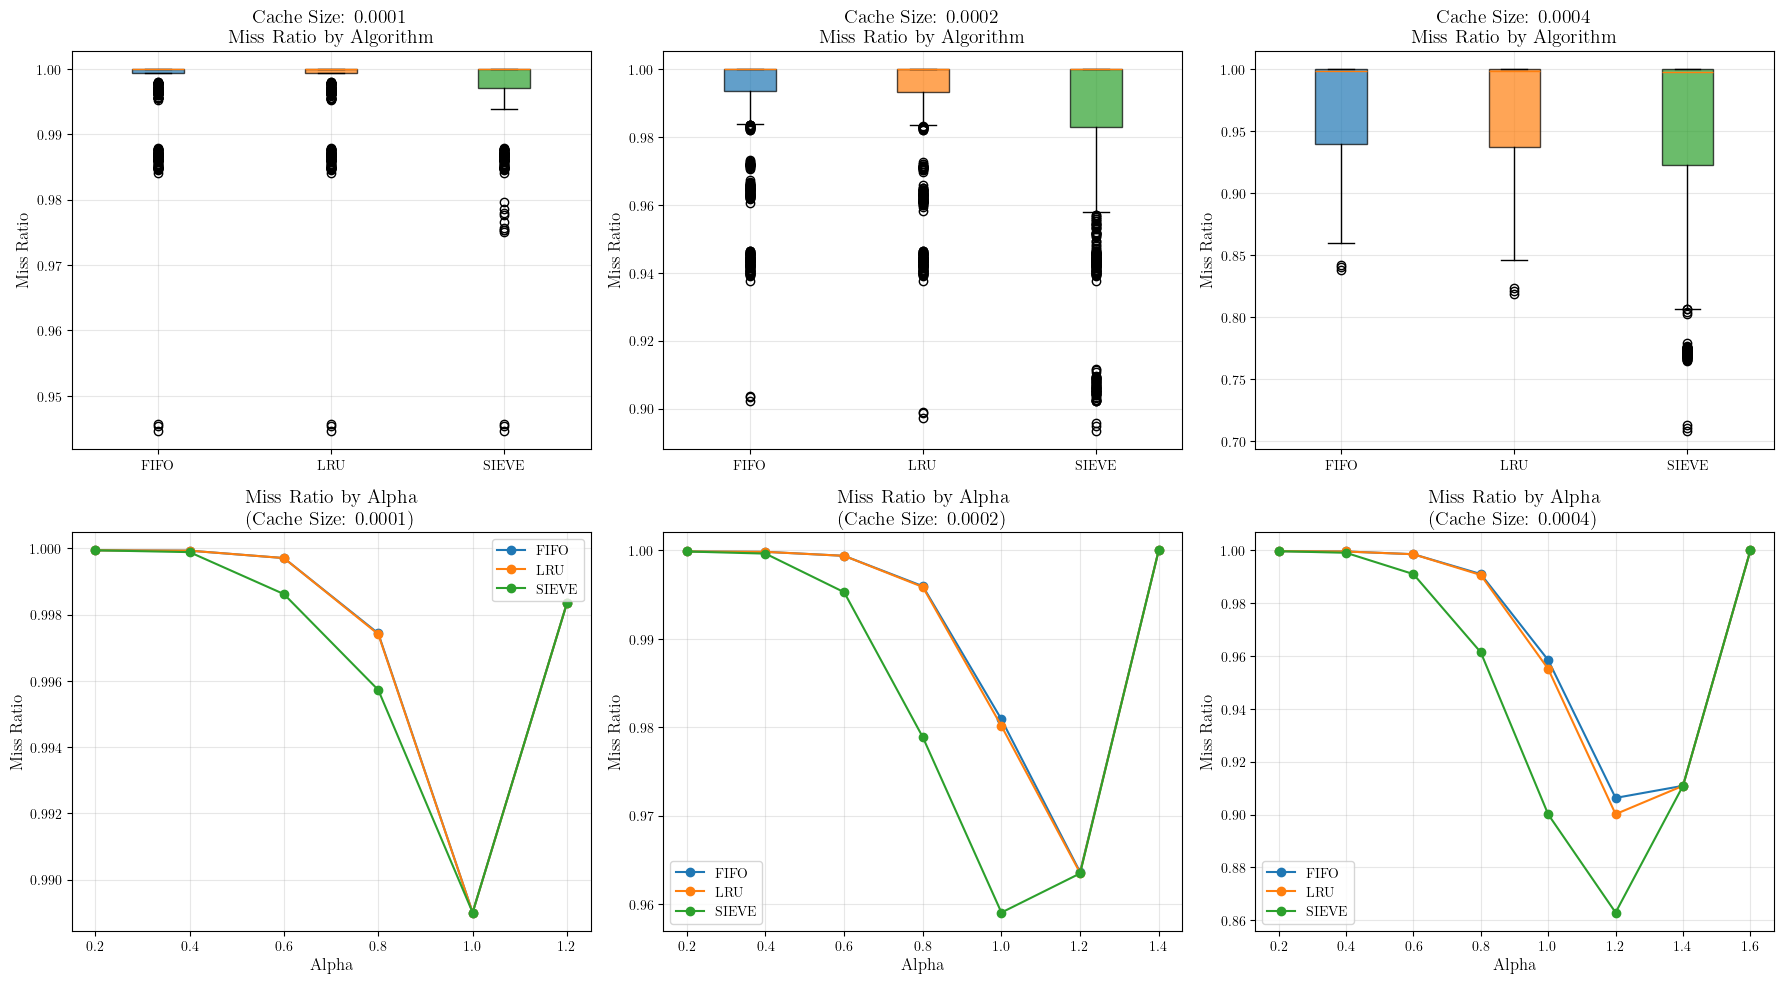

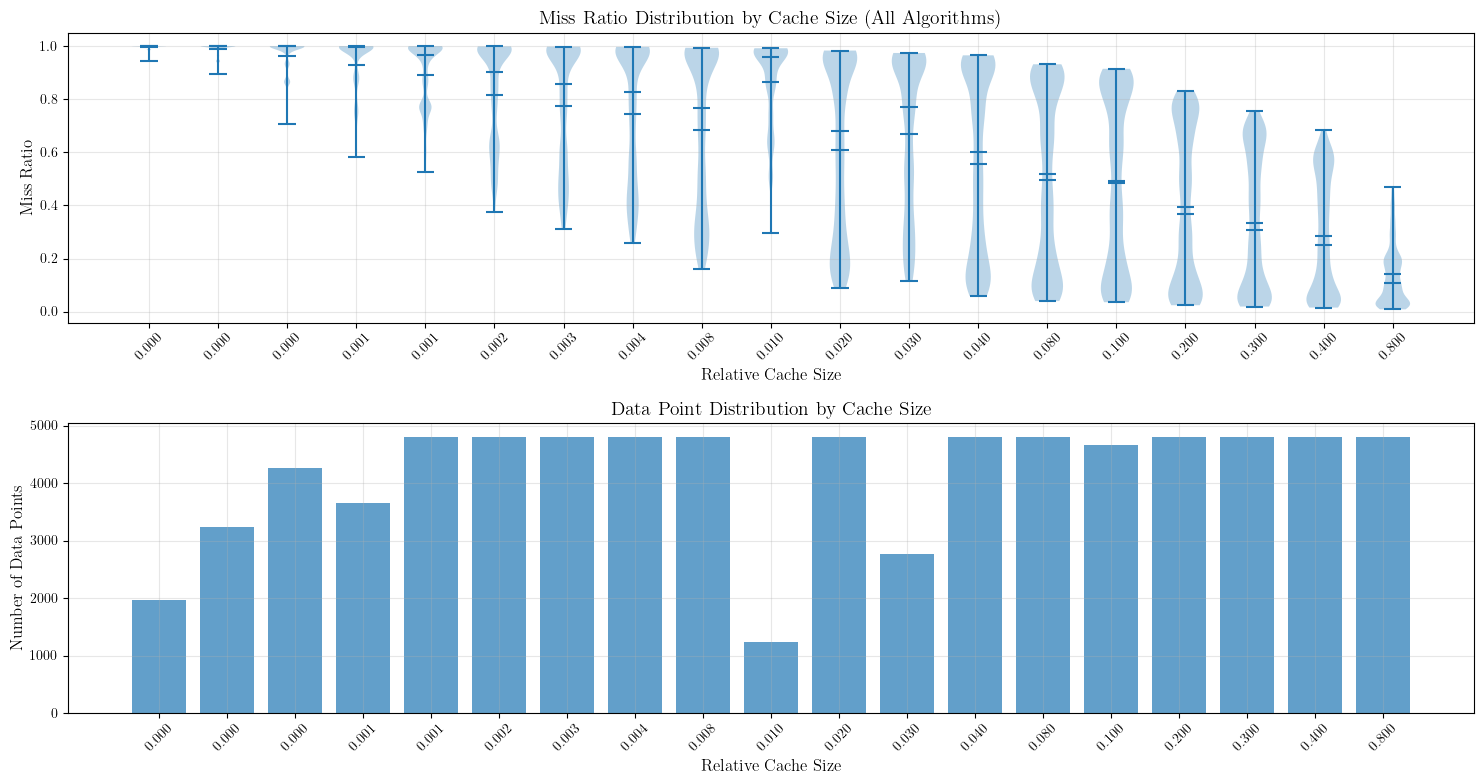

In [71]:
def analyze_peaks_visually(cache_sizes_to_analyze=None):
    """
    Create detailed visualizations for specific cache sizes to understand peaks
    """
    if cache_sizes_to_analyze is None:
        # Use the top 3 cache sizes with highest mean miss ratio
        peak_analysis = agg_mean.groupby('cache_size_relative_rounded')['miss_ratio'].mean().sort_values(ascending=False)
        cache_sizes_to_analyze = peak_analysis.head(3).index.tolist()
    
    fig, axes = plt.subplots(2, len(cache_sizes_to_analyze), figsize=(6*len(cache_sizes_to_analyze), 10))
    if len(cache_sizes_to_analyze) == 1:
        axes = axes.reshape(-1, 1)
    
    for i, cache_size in enumerate(cache_sizes_to_analyze):
        subset = results_df[results_df['cache_size_relative_rounded'] == cache_size]
        
        # Top plot: Miss ratio by algorithm (box plot)
        ax1 = axes[0, i]
        box_data = [subset[subset['algorithm'] == algo]['miss_ratio'] for algo in subset['algorithm'].unique()]
        bp = ax1.boxplot(box_data, labels=subset['algorithm'].unique(), patch_artist=True)
        
        # Color the boxes
        for j, (patch, algo) in enumerate(zip(bp['boxes'], subset['algorithm'].unique())):
            patch.set_facecolor(ALGORITHM_COLORS.get(algo, 'gray'))
            patch.set_alpha(0.7)
        
        ax1.set_title(f'Cache Size: {cache_size}\nMiss Ratio by Algorithm')
        ax1.set_ylabel('Miss Ratio')
        ax1.grid(True, alpha=0.3)
        
        # Bottom plot: Miss ratio by alpha
        ax2 = axes[1, i]
        for algo in subset['algorithm'].unique():
            algo_data = subset[subset['algorithm'] == algo]
            alpha_means = algo_data.groupby('alpha')['miss_ratio'].mean()
            ax2.plot(alpha_means.index, alpha_means.values, 
                    marker='o', label=algo, color=ALGORITHM_COLORS.get(algo, 'black'))
        
        ax2.set_title(f'Miss Ratio by Alpha\n(Cache Size: {cache_size})')
        ax2.set_xlabel('Alpha')
        ax2.set_ylabel('Miss Ratio')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create the peak analysis visualization
analyze_peaks_visually()

# Additional: Show miss ratio distribution across all cache sizes
plt.figure(figsize=(15, 8))

# Plot 1: Miss ratio distribution by cache size (violin plot)
plt.subplot(2, 1, 1)
cache_sizes = sorted(results_df['cache_size_relative_rounded'].unique())
violin_data = [results_df[results_df['cache_size_relative_rounded'] == cs]['miss_ratio'] for cs in cache_sizes]

parts = plt.violinplot(violin_data, positions=range(len(cache_sizes)), showmeans=True, showmedians=True)
plt.xticks(range(len(cache_sizes)), [f'{cs:.3f}' for cs in cache_sizes], rotation=45)
plt.xlabel('Relative Cache Size')
plt.ylabel('Miss Ratio')
plt.title('Miss Ratio Distribution by Cache Size (All Algorithms)')
plt.grid(True, alpha=0.3)

# Plot 2: Number of data points per cache size
plt.subplot(2, 1, 2)
counts = [len(results_df[results_df['cache_size_relative_rounded'] == cs]) for cs in cache_sizes]
plt.bar(range(len(cache_sizes)), counts, alpha=0.7)
plt.xticks(range(len(cache_sizes)), [f'{cs:.3f}' for cs in cache_sizes], rotation=45)
plt.xlabel('Relative Cache Size')
plt.ylabel('Number of Data Points')
plt.title('Data Point Distribution by Cache Size')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== POTENTIAL CAUSES OF PEAKS ===

1. Correlation between cache size and other parameters:

Alpha distribution at peak cache sizes vs. overall:

Cache Size 0.0001:
  Alpha values: [0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
  Alpha counts: {0.2: 360, 0.4: 360, 0.6: 339, 0.8: 300, 1.0: 300, 1.2: 300}

Cache Size 0.0002:
  Alpha values: [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4]
  Alpha counts: {0.2: 480, 0.4: 480, 0.6: 480, 0.8: 480, 1.0: 480, 1.2: 480, 1.4: 360}

Cache Size 0.0004:
  Alpha values: [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6]
  Alpha counts: {0.2: 540, 0.4: 540, 0.6: 540, 0.8: 540, 1.0: 540, 1.2: 540, 1.4: 540, 1.6: 480}

Overall alpha distribution:
  Alpha values: [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6]
  Alpha counts: {0.2: 10464, 0.4: 10440, 0.6: 10416, 0.8: 10329, 1.0: 10230, 1.2: 9999, 1.4: 9213, 1.6: 8280}

2. Algorithm performance at peak cache sizes:

Cache Size 0.0001:
             mean     std
algorithm                
FIFO       0.9976  0.0057
LRU        0.9976  0.0057
SIEVE      0

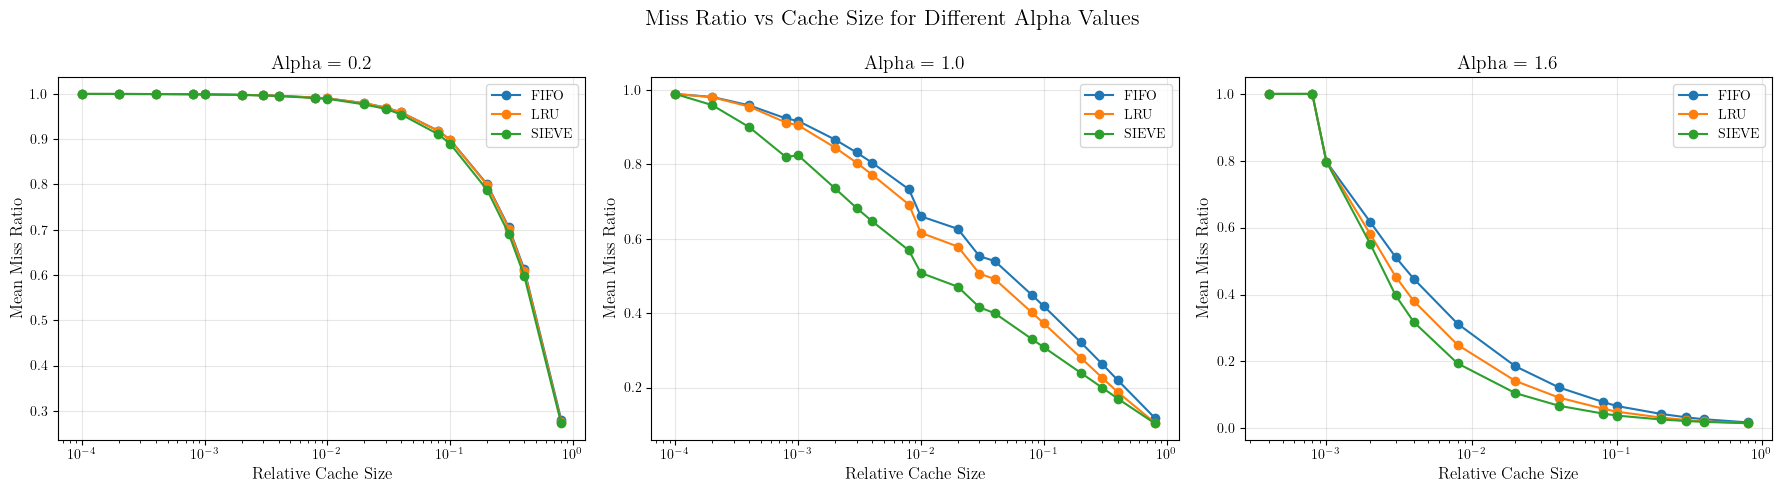


4. Statistical significance of peaks:
Overall mean miss ratio: 0.6317

Cache Size 0.0001:
  Peak mean: 0.9974 (n=1959)
  Neighbors mean: 0.9889 (n=3240)
  T-test: t=16.997, p=0.0000
  Significant difference: Yes

Cache Size 0.0002:
  Peak mean: 0.9889 (n=3240)
  Neighbors mean: 0.9744 (n=6219)
  T-test: t=15.534, p=0.0000
  Significant difference: Yes

Cache Size 0.0004:
  Peak mean: 0.9638 (n=4260)
  Neighbors mean: 0.9576 (n=6894)
  T-test: t=4.219, p=0.0000
  Significant difference: Yes


In [72]:
# Investigate potential causes of peaks
print("=== POTENTIAL CAUSES OF PEAKS ===")
print()

# 1. Check if peaks correspond to specific experimental conditions
print("1. Correlation between cache size and other parameters:")
print()

# Check if certain alpha values are more represented at peak cache sizes
peak_cache_sizes = agg_mean.groupby('cache_size_relative_rounded')['miss_ratio'].mean().sort_values(ascending=False).head(3).index

print("Alpha distribution at peak cache sizes vs. overall:")
for peak_cs in peak_cache_sizes:
    peak_subset = results_df[results_df['cache_size_relative_rounded'] == peak_cs]
    print(f"\nCache Size {peak_cs}:")
    print(f"  Alpha values: {sorted(peak_subset['alpha'].unique())}")
    print(f"  Alpha counts: {peak_subset['alpha'].value_counts().sort_index().to_dict()}")

print(f"\nOverall alpha distribution:")
print(f"  Alpha values: {sorted(results_df['alpha'].unique())}")
print(f"  Alpha counts: {results_df['alpha'].value_counts().sort_index().to_dict()}")

# 2. Check if peaks are due to algorithmic behavior at specific cache sizes
print("\n2. Algorithm performance at peak cache sizes:")
for peak_cs in peak_cache_sizes:
    peak_subset = results_df[results_df['cache_size_relative_rounded'] == peak_cs]
    print(f"\nCache Size {peak_cs}:")
    algo_performance = peak_subset.groupby('algorithm')['miss_ratio'].agg(['mean', 'std']).round(4)
    print(algo_performance)

# 3. Check if peaks are consistent across different alpha values
print("\n3. Peak consistency across alpha values:")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, alpha_val in enumerate([0.2, 1.0, 1.6]):  # Sample different alpha values
    if alpha_val in results_df['alpha'].unique():
        alpha_subset = results_df[results_df['alpha'] == alpha_val]
        alpha_agg = alpha_subset.groupby(['algorithm', 'cache_size_relative_rounded'])['miss_ratio'].mean().reset_index()
        
        ax = axes[i]
        for algo in alpha_agg['algorithm'].unique():
            df_algo = alpha_agg[alpha_agg['algorithm'] == algo]
            ax.plot(df_algo['cache_size_relative_rounded'], df_algo['miss_ratio'], 
                   marker='o', label=algo, color=ALGORITHM_COLORS.get(algo, 'black'))
        
        ax.set_xlabel('Relative Cache Size')
        ax.set_ylabel('Mean Miss Ratio')
        ax.set_title(f'Alpha = {alpha_val}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xscale('log')

plt.suptitle('Miss Ratio vs Cache Size for Different Alpha Values', fontsize=16)
plt.tight_layout()
plt.show()

# 4. Statistical test for peak significance
print("\n4. Statistical significance of peaks:")
from scipy import stats

# Compare peak cache sizes to neighboring ones
overall_mean = results_df['miss_ratio'].mean()
print(f"Overall mean miss ratio: {overall_mean:.4f}")

for peak_cs in peak_cache_sizes:
    peak_data = results_df[results_df['cache_size_relative_rounded'] == peak_cs]['miss_ratio']
    
    # Find neighboring cache sizes
    all_cache_sizes = sorted(results_df['cache_size_relative_rounded'].unique())
    peak_idx = all_cache_sizes.index(peak_cs)
    
    neighbors = []
    if peak_idx > 0:
        neighbors.append(all_cache_sizes[peak_idx - 1])
    if peak_idx < len(all_cache_sizes) - 1:
        neighbors.append(all_cache_sizes[peak_idx + 1])
    
    neighbor_data = results_df[results_df['cache_size_relative_rounded'].isin(neighbors)]['miss_ratio']
    
    if len(neighbor_data) > 0:
        t_stat, p_val = stats.ttest_ind(peak_data, neighbor_data)
        print(f"\nCache Size {peak_cs}:")
        print(f"  Peak mean: {peak_data.mean():.4f} (n={len(peak_data)})")
        print(f"  Neighbors mean: {neighbor_data.mean():.4f} (n={len(neighbor_data)})")
        print(f"  T-test: t={t_stat:.3f}, p={p_val:.4f}")
        print(f"  Significant difference: {'Yes' if p_val < 0.05 else 'No'}")

## Miss ratio vs. alpha

### Line plot

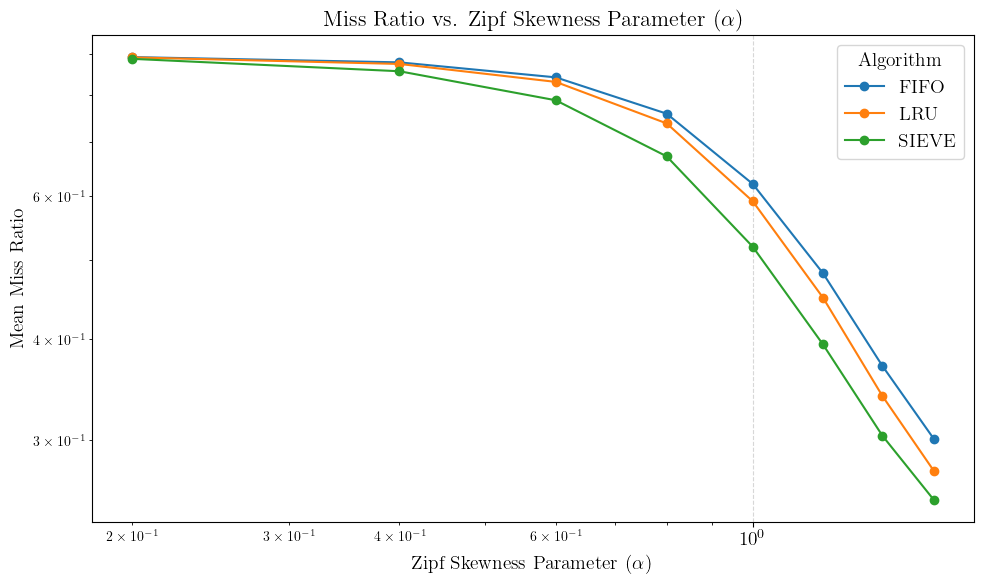

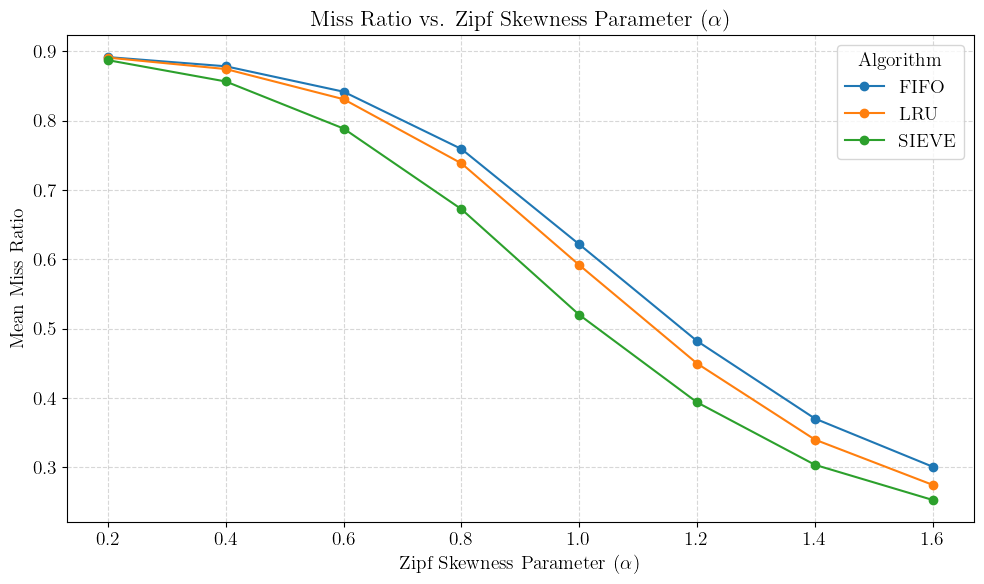

In [73]:
def plot_miss_ratio_vs_alpha(save=False, title=True, log=False):
    # Aggregate mean miss ratio by algorithm and alpha
    zipf_agg = results_df.groupby(['algorithm', 'alpha'])['miss_ratio'].mean().reset_index()

    plt.figure(figsize=(10, 6))
    for algo in zipf_agg['algorithm'].unique():
        df_algo = zipf_agg[zipf_agg['algorithm'] == algo]
        plt.plot(df_algo['alpha'], df_algo['miss_ratio'], 
                marker='o', label=algo, color=ALGORITHM_COLORS.get(algo, 'black'))

    plt.xlabel(r'Zipf Skewness Parameter ($\alpha$)', fontsize=AXIS_FONT_SIZE)
    plt.ylabel('Mean Miss Ratio', fontsize=AXIS_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)

    if log:
        plt.xscale('log')
        plt.yscale('log')

    if title: plt.title(r'Miss Ratio vs. Zipf Skewness Parameter ($\alpha$)', fontsize=TITLE_FONT_SIZE)
    plt.legend(title='Algorithm', fontsize=LEGEND_FONT_SIZE, title_fontsize=LEGEND_FONT_SIZE)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    if save: plt.savefig(os.path.join(FIGURES_SIMULATIONS_DIR, f"miss_ratio_vs_alpha{'_log' if log else ''}{'_no_title' if not title else ''}.pdf"), bbox_inches='tight')
    plt.show()

plot_miss_ratio_vs_alpha(save=False, title=True, log=True)
plot_miss_ratio_vs_alpha(save=False, title=True, log=False)

### Statistics

In [74]:
# Aggregate mean miss ratio by algorithm and alpha
zipf_agg = results_df.groupby(['algorithm', 'alpha'])['miss_ratio'].mean().reset_index()

# Print statistics for mean miss ratio by algorithm and alpha
print("Mean Miss Ratio by Algorithm and Alpha:")
print("=" * 50)

# Create a pivot table for better readability
pivot_table = zipf_agg.pivot(index='alpha', columns='algorithm', values='miss_ratio')
print(pivot_table.round(4))

# Calculate percentage advantages
sieve_vs_fifo = ((pivot_table['FIFO'] - pivot_table['SIEVE']) / pivot_table['FIFO'] * 100)
sieve_vs_lru = ((pivot_table['LRU'] - pivot_table['SIEVE']) / pivot_table['LRU'] * 100)

# Print summary statistics
print("\nSIEVE Percentage Advantage Summary:")
print("=" * 50)
print(f"{'Alpha':<8} {'vs FIFO (%)':<12} {'vs LRU (%)':<12}")
print("-" * 50)

for alpha in sorted(pivot_table.index):
    fifo_adv = sieve_vs_fifo[alpha]
    lru_adv = sieve_vs_lru[alpha]
    print(f"{alpha:<8.1f} {fifo_adv:<12.2f} {lru_adv:<12.2f}")

# Calculate absolute performance differences
sieve_vs_fifo_abs = pivot_table['FIFO'] - pivot_table['SIEVE']
sieve_vs_lru_abs = pivot_table['LRU'] - pivot_table['SIEVE']

# Print absolute performance differences
print("\nSIEVE Absolute Performance Difference (Miss Ratio):")
print("=" * 60)
print(f"{'Alpha':<8} {'vs FIFO':<12} {'vs LRU':<12} {'SIEVE':<12}")
print("-" * 60)

for alpha in sorted(pivot_table.index):
    fifo_diff = sieve_vs_fifo_abs[alpha]
    lru_diff = sieve_vs_lru_abs[alpha]
    sieve_miss = pivot_table.loc[alpha, 'SIEVE']
    print(f"{alpha:<8.1f} {fifo_diff:<12.4f} {lru_diff:<12.4f} {sieve_miss:<12.4f}")

print(f"\nNote: Positive values indicate SIEVE performs better (lower miss ratio)")


Mean Miss Ratio by Algorithm and Alpha:
algorithm    FIFO     LRU   SIEVE
alpha                            
0.2        0.8916  0.8909  0.8872
0.4        0.8783  0.8744  0.8564
0.6        0.8417  0.8309  0.7886
0.8        0.7591  0.7383  0.6723
1.0        0.6216  0.5917  0.5199
1.2        0.4821  0.4497  0.3937
1.4        0.3703  0.3400  0.3037
1.6        0.3009  0.2747  0.2529

SIEVE Percentage Advantage Summary:
Alpha    vs FIFO (%)  vs LRU (%)  
--------------------------------------------------
0.2      0.50         0.41        
0.4      2.50         2.05        
0.6      6.31         5.09        
0.8      11.43        8.95        
1.0      16.35        12.13       
1.2      18.34        12.46       
1.4      18.00        10.69       
1.6      15.93        7.92        

SIEVE Absolute Performance Difference (Miss Ratio):
Alpha    vs FIFO      vs LRU       SIEVE       
------------------------------------------------------------
0.2      0.0044       0.0037       0.8872      
0.4    

### SIEVE advantage plot

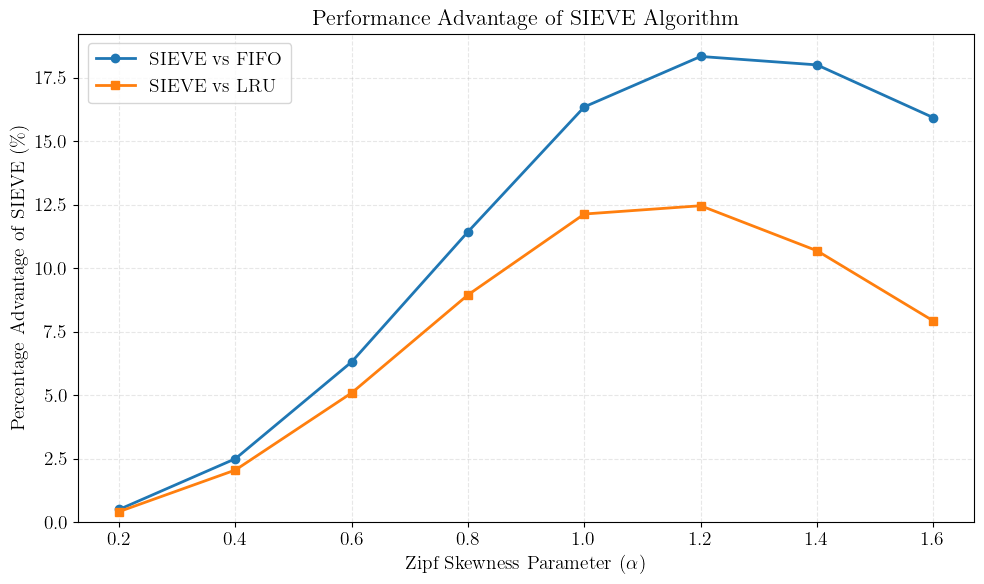

In [75]:
def plot_sieve_advantage(save=False, title=True):
    """
    Plot the percentage advantage of SIEVE compared to FIFO and LRU algorithms.
    Percentage advantage = (baseline_miss_ratio - sieve_miss_ratio) / baseline_miss_ratio * 100
    """
    # Use the already computed zipf_agg data
    pivot_data = zipf_agg.pivot(index='alpha', columns='algorithm', values='miss_ratio')
    
    # Calculate percentage advantages
    sieve_vs_fifo = ((pivot_data['FIFO'] - pivot_data['SIEVE']) / pivot_data['FIFO'] * 100)
    sieve_vs_lru = ((pivot_data['LRU'] - pivot_data['SIEVE']) / pivot_data['LRU'] * 100)
    
    plt.figure(figsize=(10, 6))
    
    # Plot percentage advantages
    plt.plot(pivot_data.index, sieve_vs_fifo, marker='o', linewidth=2, 
             label='SIEVE vs FIFO', color=FIFO_COLOR, markersize=6)
    plt.plot(pivot_data.index, sieve_vs_lru, marker='s', linewidth=2, 
             label='SIEVE vs LRU', color=LRU_COLOR, markersize=6)
    
    plt.xlabel(r'Zipf Skewness Parameter ($\alpha$)', fontsize=AXIS_FONT_SIZE)
    plt.ylabel('Percentage Advantage of SIEVE (\%)', fontsize=AXIS_FONT_SIZE)

    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)
    
    # Set y-axis to start at 0
    plt.ylim(bottom=0)
    
    if title:
        plt.title('Performance Advantage of SIEVE Algorithm', fontsize=TITLE_FONT_SIZE)
    
    plt.legend(fontsize=LEGEND_FONT_SIZE)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    if save:
        plt.savefig(os.path.join(FIGURES_SIMULATIONS_DIR, f"sieve_advantage{'_no_title' if not title else ''}.pdf"), bbox_inches='tight')
    
    plt.show()

plot_sieve_advantage(save=False, title=True)

## Miss ratio vs. alpha + relative cache size

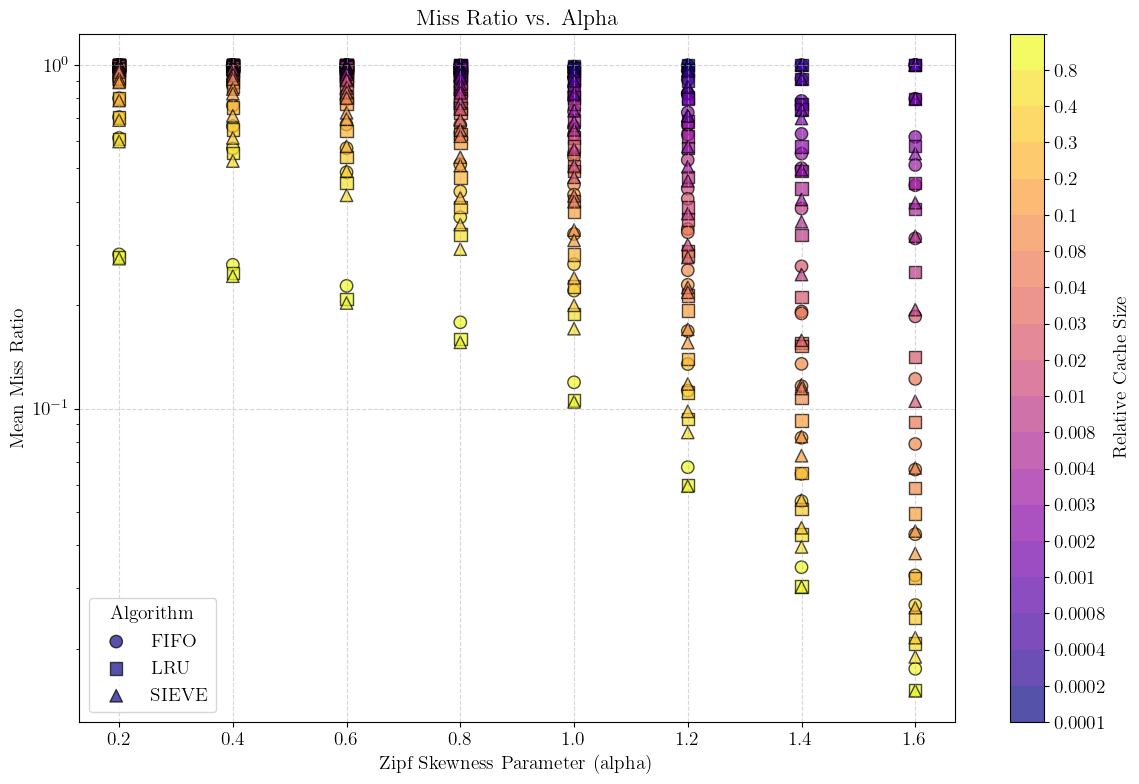

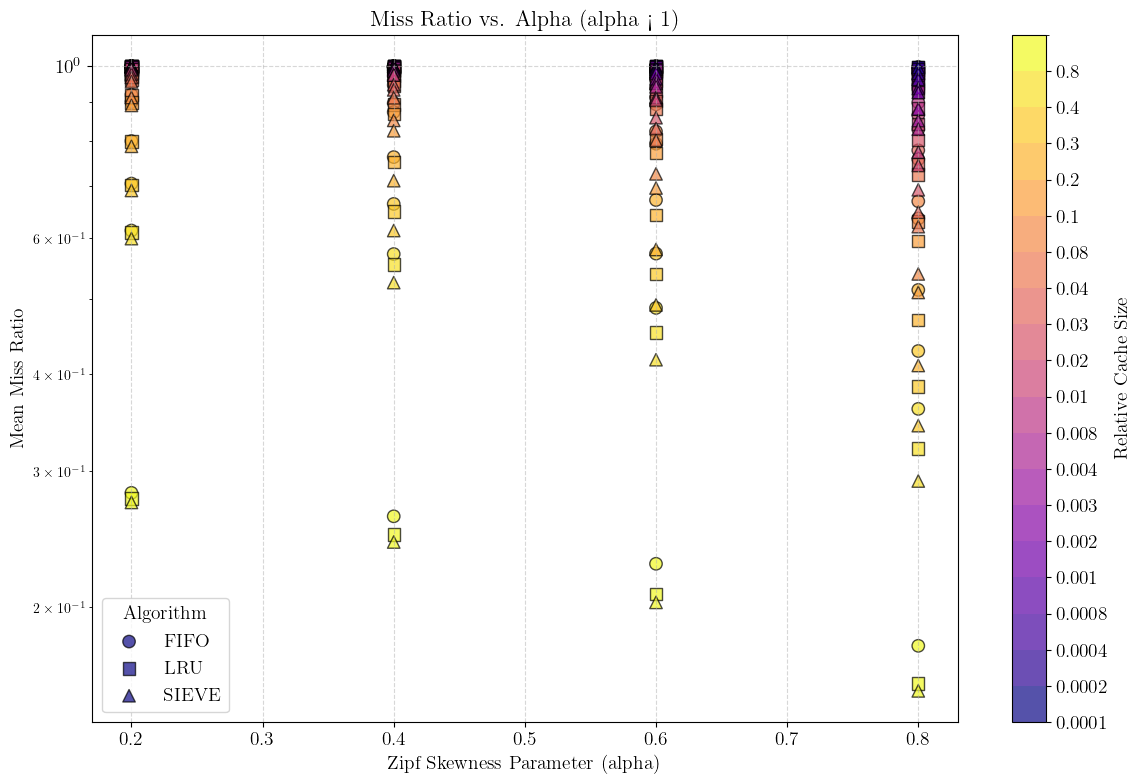

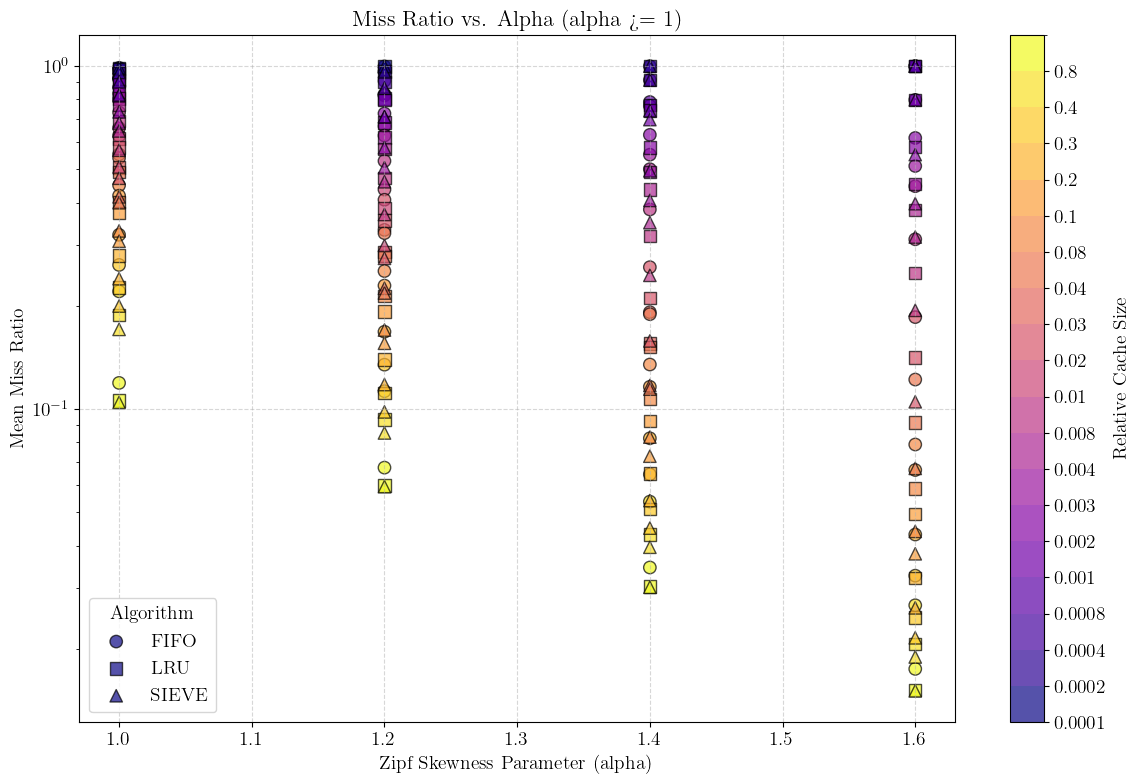

In [76]:
# Pivot the data to have (alpha, cache_size_relative_rounded) as x, algorithm as lines
pivot_df = results_df.groupby(['algorithm', 'alpha', 'cache_size_relative_rounded'])['miss_ratio'].mean().reset_index()

# Assign a unique marker for each algorithm
markers = {
    'FIFO': 'o',
    'LRU': 's', 
    'SIEVE': '^'
}

cmap = 'plasma'

# Only use the specified relative cache sizes
relevant_sizes = sorted(pivot_df['cache_size_relative_rounded'].unique())
filtered_df = pivot_df[pivot_df['cache_size_relative_rounded'].isin(relevant_sizes)]

# # Create a colormap and norm that matches the relevant sizes
cmap = plt.get_cmap('plasma', len(relevant_sizes))
norm = mpl.colors.BoundaryNorm(boundaries=np.append(relevant_sizes, relevant_sizes[-1]+0.001), ncolors=len(relevant_sizes))

# Split the filtered_df into two based on alpha
below_1 = filtered_df[filtered_df['alpha'] < 1]
above_eq_1 = filtered_df[filtered_df['alpha'] >= 1]

def plot_scatter(df, title=None, save=False):
    plt.figure(figsize=(12, 8))
    scs = []
    for algo in df['algorithm'].unique():
        df_algo = df[df['algorithm'] == algo]
        sc = plt.scatter(
            df_algo['alpha'],
            df_algo['miss_ratio'],
            c=df_algo['cache_size_relative_rounded'],
            cmap=cmap,
            norm=norm,
            s=80,
            alpha=0.7,
            marker=markers.get(algo, 'o'),
            label=algo,
            edgecolor='black'
        )
        scs.append(sc)
    plt.xlabel('Zipf Skewness Parameter (alpha)', fontsize=AXIS_FONT_SIZE)
    plt.ylabel('Mean Miss Ratio', fontsize=AXIS_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)

    if title: plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.yscale('log')
    cbar = plt.colorbar(scs[0], ticks=relevant_sizes, label='Relative Cache Size')
    cbar.ax.set_yticklabels([str(s) for s in relevant_sizes])
    
    # Set colorbar font sizes
    cbar.ax.tick_params(labelsize=TICKS_FONT_SIZE)
    cbar.set_label('Relative Cache Size', fontsize=LEGEND_FONT_SIZE)
    
    plt.legend(title='Algorithm', fontsize=LEGEND_FONT_SIZE, title_fontsize=LEGEND_FONT_SIZE)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    if save:
        plt.savefig(os.path.join(FIGURES_SIMULATIONS_DIR, f"miss_ratio_heat_map{'_no_title' if not title else ''}.pdf"), bbox_inches='tight')

    plt.show()


plot_scatter(filtered_df, "Miss Ratio vs. Alpha")
plot_scatter(below_1, 'Miss Ratio vs. Alpha (alpha < 1)')
plot_scatter(above_eq_1, 'Miss Ratio vs. Alpha (alpha >= 1)')

## Miss ratio distribution

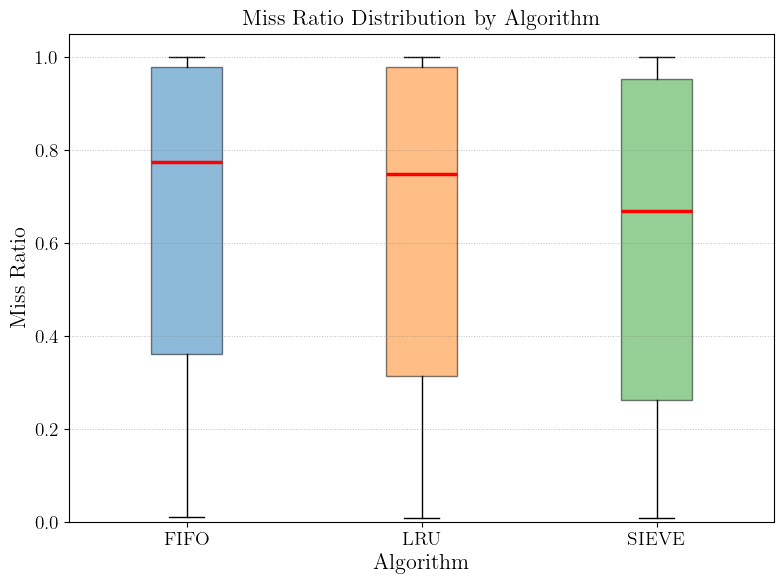

In [77]:
def plot_boxplot_miss_ratio(save=False, title=True):
    plt.figure(figsize=(8, 6))

    # Prepare data for colored boxplots
    box_data = [results_df[results_df['algorithm'] == algo]['miss_ratio'] for algo in results_df['algorithm'].unique()]
    algorithms = results_df['algorithm'].unique()

    # Create boxplot with colors
    bp = plt.boxplot(box_data, labels=algorithms, patch_artist=True, medianprops=dict(color='red', linewidth=2.5))

    # Color each box with algorithm-specific colors
    for i, (patch, algo) in enumerate(zip(bp['boxes'], algorithms)):
        patch.set_facecolor(ALGORITHM_COLORS.get(algo, 'gray'))
        patch.set_alpha(0.5)

    if title: plt.title('Miss Ratio Distribution by Algorithm', fontsize=16)
    plt.xlabel('Algorithm', fontsize=16)
    plt.ylabel('Miss Ratio', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(0, 1.05)

    # Add horizontal grid lines
    ax = plt.gca()
    for y in ax.get_yticks():
        ax.axhline(y, color='gray', linestyle=':', linewidth=0.7, alpha=0.5)

    plt.tight_layout()

    if save:
        plt.savefig(os.path.join(FIGURES_SIMULATIONS_DIR, f"miss_ratio_distribution{'_no_title' if not title else ''}.pdf"), bbox_inches='tight')

    plt.show()

plot_boxplot_miss_ratio(title=True, save=False)

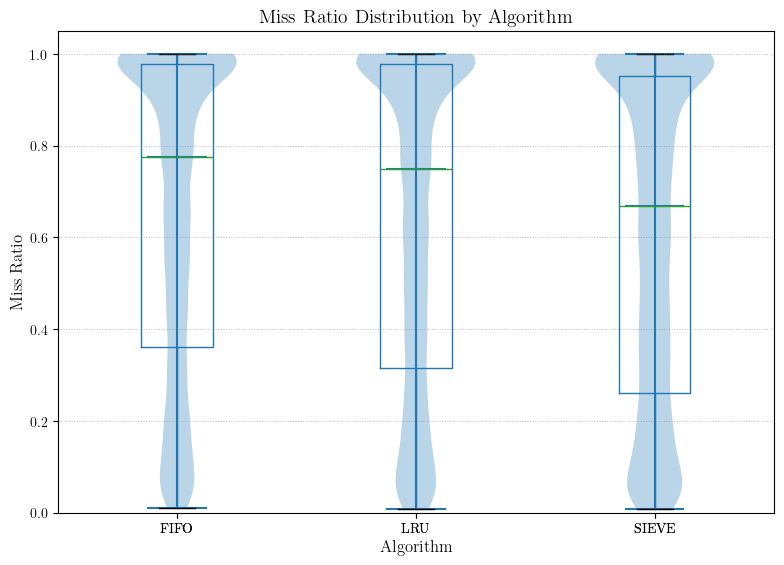

In [78]:
plt.figure(figsize=(8, 6))
subset_violin = [results_df[results_df['algorithm'] == algo]['miss_ratio'] for algo in results_df['algorithm'].unique()]
plt.violinplot(subset_violin, showmeans=False, showmedians=True)
plt.xticks(range(1, len(results_df['algorithm'].unique()) + 1), results_df['algorithm'].unique())
ax = plt.gca()
results_df.boxplot(column='miss_ratio', by='algorithm', ax=ax, grid=False)
plt.title('Miss Ratio Distribution by Algorithm')
plt.suptitle('')
plt.xlabel('Algorithm')
plt.ylabel('Miss Ratio')
plt.tight_layout()
ax.set_ylim(0, 1.05)

for y in ax.get_yticks():
    ax.axhline(y, color='gray', linestyle=':', linewidth=0.7, alpha=0.5)

plt.show()

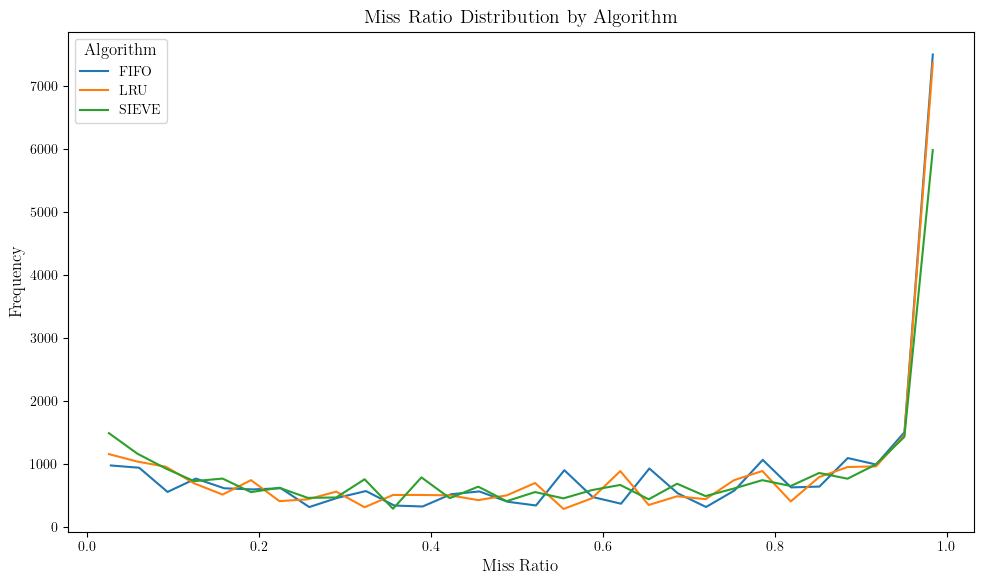

In [79]:
for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    counts, bin_edges = np.histogram(data, bins=30)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(bin_centers, counts, label=algo, color=ALGORITHM_COLORS.get(algo, 'black'))
plt.xlabel('Miss Ratio')
plt.ylabel('Frequency')
plt.title('Miss Ratio Distribution by Algorithm')
plt.legend(title='Algorithm')
plt.tight_layout()
plt.show()

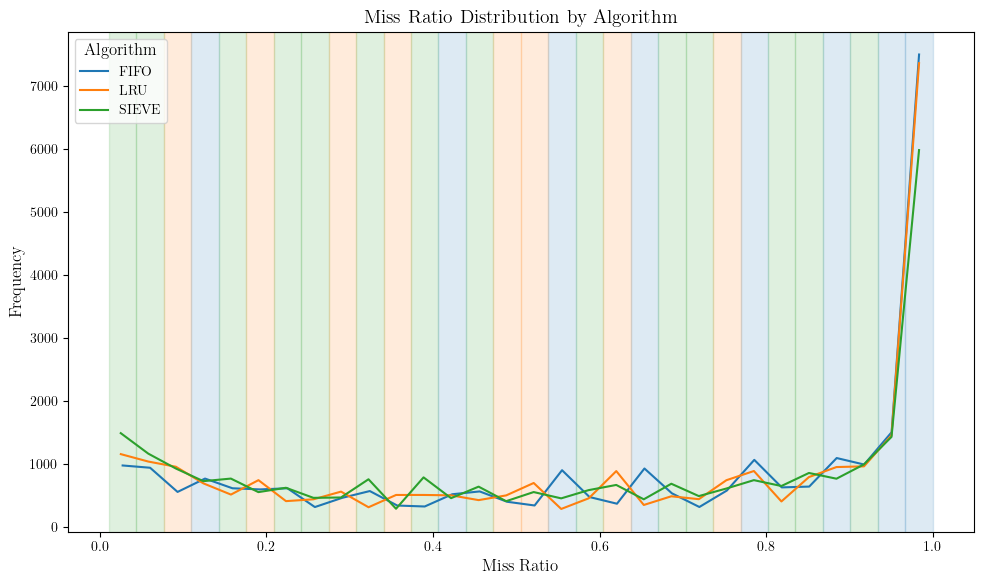

In [80]:
plt.figure(figsize=(10, 6))

# Store histogram data for each algorithm
hist_data = {}
bin_edges = None

for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    counts, edges = np.histogram(data, bins=30)
    bin_centers = (edges[:-1] + edges[1:]) / 2
    hist_data[algo] = counts
    if bin_edges is None:
        bin_edges = edges
    plt.plot(bin_centers, counts, label=algo, color=ALGORITHM_COLORS.get(algo, 'black'))

# Find the algorithm with the highest frequency for each bin
all_counts = np.array([hist_data[algo] for algo in results_df['algorithm'].unique()])
max_algo_idx = np.argmax(all_counts, axis=0)
algos = list(results_df['algorithm'].unique())
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(len(bin_edges) - 1):
    algo_idx = max_algo_idx[i]
    plt.axvspan(bin_edges[i], bin_edges[i+1], color=colors[algo_idx], alpha=0.15)

plt.xlabel('Miss Ratio')
plt.ylabel('Frequency')
plt.title('Miss Ratio Distribution by Algorithm')
plt.legend(title='Algorithm')
plt.tight_layout()
plt.show()

## Cumulative probability

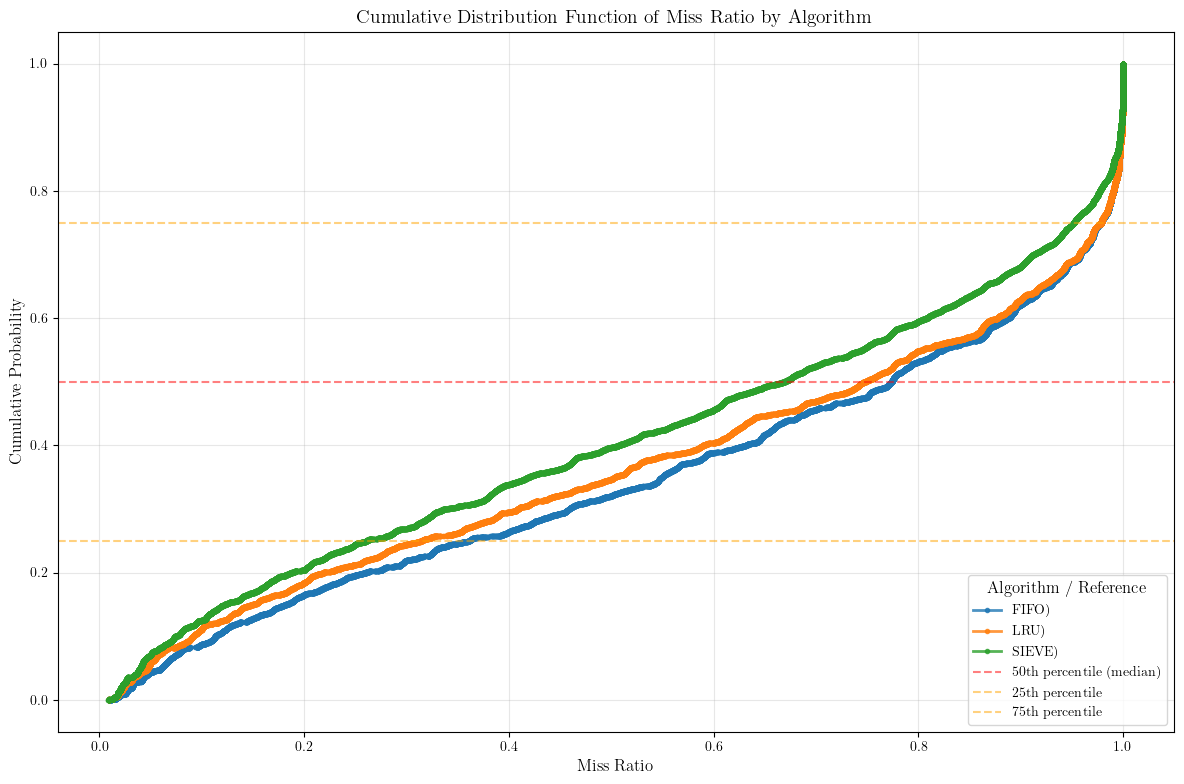

Percentile Analysis for Miss Ratio by Algorithm:
Algorithm  25th %   50th %   75th %   90th %   95th %  
------------------------------------------------------------
FIFO       0.3610   0.7739   0.9786   0.9988   0.9999  
LRU        0.3147   0.7479   0.9786   0.9988   0.9999  
SIEVE      0.2611   0.6691   0.9517   0.9979   0.9999  

Performance Comparison (Probability of Miss Ratio < 0.1):
------------------------------------------------------------
FIFO: 0.087 (8.7%)
LRU: 0.111 (11.1%)
SIEVE: 0.125 (12.5%)

Performance Comparison (Probability of Miss Ratio < 0.2):
------------------------------------------------------------
FIFO: 0.165 (16.5%)
LRU: 0.184 (18.4%)
SIEVE: 0.204 (20.4%)


In [81]:
# Cumulative probability plot for miss ratio by algorithm
plt.figure(figsize=(12, 8))

# Create cumulative probability plots for each algorithm
for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    
    # Sort the data
    sorted_data = np.sort(data)
    
    # Calculate cumulative probabilities (empirical CDF)
    n = len(sorted_data)
    y = np.arange(1, n + 1) / n
    
    # Plot the CDF
    plt.plot(sorted_data, y, marker='o', markersize=3, linewidth=2, 
             label=f'{algo})', alpha=0.8, color=ALGORITHM_COLORS.get(algo, 'black'))

plt.xlabel('Miss Ratio')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Function of Miss Ratio by Algorithm')
plt.legend(title='Algorithm')
plt.grid(True, alpha=0.3)

# Add some reference lines
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50th percentile (median)')
plt.axhline(y=0.25, color='orange', linestyle='--', alpha=0.5, label='25th percentile')
plt.axhline(y=0.75, color='orange', linestyle='--', alpha=0.5, label='75th percentile')

# Update legend to include reference lines
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, title='Algorithm / Reference', loc='lower right')

plt.tight_layout()
plt.show()

# Print percentile analysis
print("Percentile Analysis for Miss Ratio by Algorithm:")
print("=" * 60)
print(f"{'Algorithm':<10} {'25th %':<8} {'50th %':<8} {'75th %':<8} {'90th %':<8} {'95th %':<8}")
print("-" * 60)

for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    p25 = np.percentile(data, 25)
    p50 = np.percentile(data, 50)  # median
    p75 = np.percentile(data, 75)
    p90 = np.percentile(data, 90)
    p95 = np.percentile(data, 95)
    
    print(f"{algo:<10} {p25:<8.4f} {p50:<8.4f} {p75:<8.4f} {p90:<8.4f} {p95:<8.4f}")

# Performance comparison analysis
print(f"\nPerformance Comparison (Probability of Miss Ratio < 0.1):")
print("-" * 60)
for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    prob_low_miss = (data < 0.1).mean()
    print(f"{algo}: {prob_low_miss:.3f} ({prob_low_miss*100:.1f}%)")

print(f"\nPerformance Comparison (Probability of Miss Ratio < 0.2):")
print("-" * 60)
for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    prob_low_miss = (data < 0.2).mean()
    print(f"{algo}: {prob_low_miss:.3f} ({prob_low_miss*100:.1f}%)")

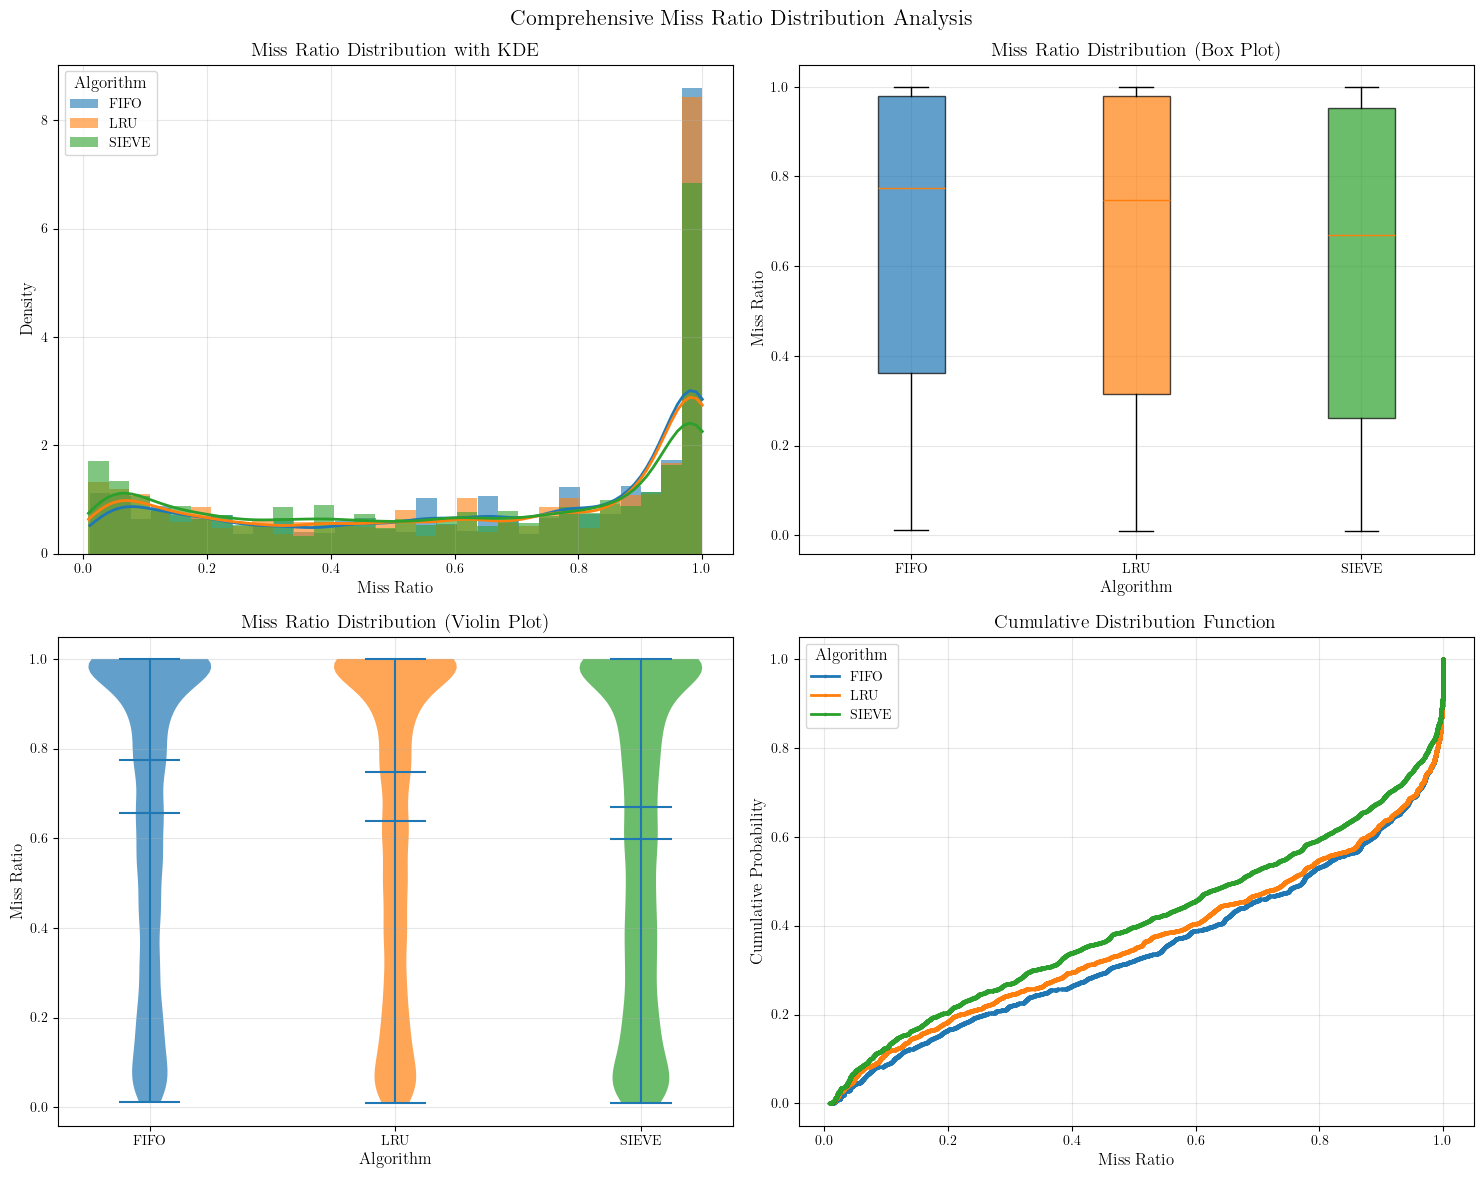

\nSummary Statistics by Algorithm:
\nFIFO:
  Mean: 0.6575
  Median: 0.7739
  Std Dev: 0.3361
  Min: 0.0111
  Max: 1.0000
  25th percentile: 0.3610
  75th percentile: 0.9786
\nLRU:
  Mean: 0.6386
  Median: 0.7479
  Std Dev: 0.3467
  Min: 0.0089
  Max: 1.0000
  25th percentile: 0.3147
  75th percentile: 0.9786
\nSIEVE:
  Mean: 0.5988
  Median: 0.6691
  Std Dev: 0.3487
  Min: 0.0088
  Max: 1.0000
  25th percentile: 0.2611
  75th percentile: 0.9517


In [82]:
# Comprehensive miss ratio distribution analysis
from scipy import stats

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Histogram with density curves
for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    
    # Histogram
    ax1.hist(data, bins=30, alpha=0.6, label=algo, density=True, 
             color=ALGORITHM_COLORS.get(algo, 'gray'))
    
    # Kernel density estimation
    kde = stats.gaussian_kde(data)
    x_range = np.linspace(data.min(), data.max(), 100)
    ax1.plot(x_range, kde(x_range), linewidth=2, 
             color=ALGORITHM_COLORS.get(algo, 'black'))

ax1.set_xlabel('Miss Ratio')
ax1.set_ylabel('Density')
ax1.set_title('Miss Ratio Distribution with KDE')
ax1.legend(title='Algorithm')
ax1.grid(True, alpha=0.3)

# 2. Box plots
box_data = [results_df[results_df['algorithm'] == algo]['miss_ratio'] for algo in results_df['algorithm'].unique()]
bp = ax2.boxplot(box_data, labels=results_df['algorithm'].unique(), patch_artist=True)

# Color the box plots
algorithms_list = list(results_df['algorithm'].unique())
for i, (patch, algo) in enumerate(zip(bp['boxes'], algorithms_list)):
    patch.set_facecolor(ALGORITHM_COLORS.get(algo, 'gray'))
    patch.set_alpha(0.7)

ax2.set_xlabel('Algorithm')
ax2.set_ylabel('Miss Ratio')
ax2.set_title('Miss Ratio Distribution (Box Plot)')
ax2.grid(True, alpha=0.3)

# 3. Violin plots
parts = ax3.violinplot(box_data, showmeans=True, showmedians=True)
for i, (part, algo) in enumerate(zip(parts['bodies'], algorithms_list)):
    part.set_facecolor(ALGORITHM_COLORS.get(algo, 'gray'))
    part.set_alpha(0.7)

ax3.set_xticks(range(1, len(results_df['algorithm'].unique()) + 1))
ax3.set_xticklabels(results_df['algorithm'].unique())
ax3.set_xlabel('Algorithm')
ax3.set_ylabel('Miss Ratio')
ax3.set_title('Miss Ratio Distribution (Violin Plot)')
ax3.grid(True, alpha=0.3)

# 4. Cumulative distribution function
for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    sorted_data = np.sort(data)
    y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    ax4.plot(sorted_data, y, marker='.', markersize=3, label=algo, 
             linewidth=2, color=ALGORITHM_COLORS.get(algo, 'black'))

ax4.set_xlabel('Miss Ratio')
ax4.set_ylabel('Cumulative Probability')
ax4.set_title('Cumulative Distribution Function')
ax4.legend(title='Algorithm')
ax4.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Miss Ratio Distribution Analysis', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\\nSummary Statistics by Algorithm:")
print("=" * 50)
for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    print(f"\\n{algo}:")
    print(f"  Mean: {data.mean():.4f}")
    print(f"  Median: {data.median():.4f}")
    print(f"  Std Dev: {data.std():.4f}")
    print(f"  Min: {data.min():.4f}")
    print(f"  Max: {data.max():.4f}")
    print(f"  25th percentile: {data.quantile(0.25):.4f}")
    print(f"  75th percentile: {data.quantile(0.75):.4f}")